<div style="display:flex; border-bottom:4px solid gray; background-color: white; padding: 10px;">
    <div>
        <h2 style="margin:10px 0px 0px 0px;">Master Thesis - Spring 2023</h2>
        <h4 style="margin:10px 10px 10px 0px;"><i>Artificial Intelligence - Data Science</i></h4>
    </div>
    <img src="https://raw.githubusercontent.com/JABE22/Image/main/Logos/logo_ural-federal-university.png" style="width:300px; height:150px; margin-right: 25px;" align='right' />
</div>
<h4 style="margin-top:10px; text-align:right; font-size: 20px; margin-right: 25px;"> Jarno Matarmaa - 03.2023 - Version draft</h4>

# Sport Activity Classification using Standard CML Models and Time Series Analysis
### Part (2/3), Time Series Classification

---

**TASKS**
- [25.1.2023] Check if there is possibility to get optimal intervals from single sequences using some threshold values for speed etc.
- [25.2.2023] Include signal length analysis.

**CHANGE LOG**

**QUESTIONS**

---

<a id="0"></a> <br>
## I - Table of Contents

#### [1 - Data import and preview](#1)
* [1A - Libraries](#11)
* [1B - Data download](#11)

#### [2 - Dataset](#2)
* [2A - Data setup](#21)
* [2B - Train-Test data splitting *(stratified by y)*](#22)
* [2C - Data Standardization *(for visualization)*](#23)

#### [3 - Univariate Time Series Classification (UTSC)](#3)
* [3A - Libraries and functions](#31)
* [3B - Data setup](#32)
* [3C - Univariate TSC model classification](#33)

#### [4 - Multivariate Time Series Classification (MTSC)](#4)
* [4A - Libraries and functions](#41)
* [4B - Data setup](#42)
* [4C - Multivariate TSC model classification](#43)
* [4D - Ensemble classification](#44)

#### [5 - Test Section](#5)
* [5A - Column ensemble in **Basic Motions** dataset](#51)
* [5B - Hyperparameter list](#52)
* [5C - CML model test in tabular format of the case data](#53)

---

<a id="1"></a> <br>
## [▲](#0) 1 - Data import and preview

<a id="11"></a> <br>
### [▲](#1) 1A - Libraries

In [1]:
# System tools
import os
import sys
# File structure
from directory_structure import Tree
# Data manipulation tools
import pandas as pd
import numpy as np
import math
# Datetime
import datetime
# Data visualization tools
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline
# Seaborn setup
import seaborn as sns

C:\Users\jarno\AppData\Roaming\Python\Python38\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
plt.style.use('./styles/plotstyles.mplstyle')
cmap = sns.color_palette("muted", 10)
THEMA_COLOR = cmap[9]
#plt.style.use('default')
#sns.set_style('white', { 'axes.spines.right': False, 'axes.spines.top': False})

In [3]:
run_start = datetime.datetime.now()

---

<a id="12"></a> <br>
### [▲](#1) 1B - Data download

File path setup

In [4]:
DATA_PATH = "C:/Users/jarno/OneDrive - УрФУ/STUDIES/MASTER/DATA/"
DATA_PATH_ORG = "C:/Users/jarno/OneDrive - УрФУ/STUDIES/DesignWorkshop/DesignWorkshopProject/DATA/CSVDATA/SET1/"

In [5]:
results_filepath = DATA_PATH + 'results/'
preds_filepath = DATA_PATH + 'predictions/'

In [6]:
path = Tree(DATA_PATH, absolute=False)
print(path)

📂 DATA
|_📁 case_data
|_📁 data_arrays
|_📁 predictions
|_📁 results
|_📁 results_S-CML
|_📄 ALT-DATA_std_1160x69
|_📄 HR-DATA_std_1160x69
|_📄 SPD-DATA_std_1160x69
|_📄 TARGET-DATA_1160x1
|_📄 TARGET-DATA_1160x69


We use pickle api to handle numpy format data (.pkl)

In [7]:
import pickle as cPickle

In [8]:
SEQ_SEGMENTED = cPickle.load( open( "DATA/data_arrays/seq_segmented.pkl", "rb" ) )
INDEX_DATA = pd.read_csv("DATA/data_arrays/index_data.csv")
SEQ_SEGMENTED_LABELS = pd.read_csv("DATA/data_arrays/seq_segmented_labels.csv")

---

<a id="2"></a> <br>
## [▲](#0) 2 - Data setup

<a id="21"></a> <br>
### [▲](#2) 2A - Train-Test data splitting *(stratified by y)*

- Dataset generation from the sequencies
- Train and Test splits
- Functions for data variable initialization
- Global variable `SEQ_LEN` will be initialized

In [9]:
# Data manipulation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sktime.datatypes._panel._convert import from_2d_array_to_nested
from sktime.transformations.panel.reduce import Tabularizer

In [10]:
# These variables need to defined here to avoid (not defined warning in the Data setup functions)
DATA, LABELS = (None, None)

**Data setup functions**

Function to create dataset

In [11]:
'''
This is a function to create interlaced univariate signals from 3-dimensional data given as parameter (sequences)

Function can split sequences to a smaller parts (seq_start - seq_end) parameters
    - If sequences has already desired size, use seq_start=0 and seq_end=sequences.shape[1] * sequences.shape[2], 
      for example, if sequences.shape = (1160, 69, 3) => 69 * 3 = 207
    - Default values are set to [0, 100]

Thus, this function generates equal length segments as an output with a certain precondition:
    - Interval length [seq_start,seq_end] must be equal or greater than the length of shortest sequence multiplied by sequences.shape[2]
    - For example, if sequences.shape = (1160, [20-69], 3), interval length [seq_start,seq_end] must be 20 * 3 = 60 at the maximum.

Example:

SEGS.shape = (1160, 69, 3)
LBLS.shape = (1160,)

Proper function call example to use all the input data:

x_data, y_data = create_dataset(SEGS, LBLS, 0, 207, True, True)

x_data.shape = (1160, 207)  (has equal length segments 207)
y_data.shape = (1160,)

If you want to cut signals after interlation, you can select the desired interval using seq_start and seq_end as you wish

'''

def create_dataset(sequences, targets, seq_start=0, seq_end=100, std=False, info=True):

    if info: print("\nSequence/Targets length validity check: ", len(sequences), len(targets))

    target = targets.label.astype('category').cat.codes

    seq_len = seq_end - seq_start

    x_data = np.zeros((len(sequences), seq_len))
    y_data = np.zeros(len(sequences))

    if info: print(x_data.shape, y_data.shape)

    for i, s in zip(range(0,len(sequences)), sequences):
        # s = 69x3 shape single 3-dimensional segment/sequence 
        if info: print(i,s.shape)
        # Sequence manipulation
        signal = s.reshape(-1,1)                 # Generates interlation operation: (69,3) => (207,1) 
        signal = np.squeeze(np.asarray(signal))  # Remove axes of length one:       (207,1) => (207,)
        signal = signal[seq_start:seq_end]       # Selects sub segments, e.g. signal[0:100] => (100,)
        #if info: print(signal.shape)
        x_data[i] = signal
        y_data[i] = target[i]

    if std:
        if info: print("Standardization")
        x_data = StandardScaler().fit_transform(x_data)

    print('X:', x_data.shape, ' y:', y_data.shape)

    return x_data, y_data

Nested data variable reset function

In [12]:
# Run this if data variable reset needed
def initdata_xynested(seq_start, seq_end):
    global x_data, y_data
    global x_train, x_test, y_train, y_test
    global X_train_nest, X_test_nest
    # The whole data
    x_data, y_data = create_dataset(DATA, LABELS, seq_start=seq_start, seq_end=seq_end, std=False, info=False)
    # Train-Test data splits
    x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=24, stratify=y_data, shuffle=True)
    print('Train:', x_train.shape, y_train.shape, 'Test:', x_test.shape, y_test.shape)
    # Multivariate
    X_train_nest = from_2d_array_to_nested(x_train)
    X_test_nest  = from_2d_array_to_nested(x_test)

Nested data variable reset function (Standard)

In [13]:
# Run this if standard data variable reset needed
def initdata_xynested_std(seq_start, seq_end):
    global x_data_std, y_data
    global x_train_std, x_test_std, y_train, y_test
    global X_train_nest_std, X_test_nest_std
    # The whole data (standard)
    x_data_std, y_data = create_dataset(DATA, LABELS, seq_start=seq_start, seq_end=seq_end, std=True, info=False)
    # Train-Test data splits (standard)
    x_train_std, x_test_std, y_train, y_test = train_test_split(x_data_std, y_data, test_size=0.2, random_state=24, stratify=y_data, shuffle=True)
    print('Train:', x_train_std.shape, y_train.shape, 'Test:', x_test_std.shape, y_test.shape)
    # Multivariate
    X_train_nest_std = from_2d_array_to_nested(x_train_std)
    X_test_nest_std  = from_2d_array_to_nested(x_test_std)

Tabular data reset function

- This function uses global variables `X_train_nest_std`, `X_test_nest_std` and tabularizes them. Therefore recommended to use only together with nested data variable reset functions
- New global variables `X_train_tab`, `X_test_tab`, `X_train_tab_std` and `X_test_tab_std` will be initialized

In [14]:
def initdata_xytabular(std=False):
    global X_train_tab, X_test_tab
    tabu = Tabularizer()
    X_train_tab = tabu.fit_transform(X_train_nest)
    X_test_tab = tabu.fit_transform(X_test_nest)

    if std:
        global X_train_tab_std, X_test_tab_std
        tabu = Tabularizer()
        X_train_tab_std = tabu.fit_transform(X_train_nest_std)
        X_test_tab_std = tabu.fit_transform(X_test_nest_std)

Data reset function

`init_data(seq_start, seq_end, nest=True, tab=False, std=False)`

In [15]:
def init_data(seq_start, seq_end, nest=True, tab=False, std=False):
    # Initilaizes nested data variables for sktime classification models
    if nest:
        initdata_xynested(seq_start, seq_end)
        # Standard
        if std:
            initdata_xynested_std(seq_start, seq_end)

    # Initializes tabular data for sklearn classifiers
    if tab:
        initdata_xytabular()
        # Standard
        if std:
            initdata_xytabular(std=True)

**Initialize data**
- Initializes global data variables according to the given parameters
- Creates the data splits (and feedback prints according to the *create_dataset()* function)

***Important note!***

In variable `SEQ_SEGMENTED` data is already in equal length segments from the interval of `[0,1000]` (5x200). So, when creating segments it is defined that we get 5 splits in the length of 200 from the original sequence. It implies that `init_data()` function call can therefore use the range of `[0,600] (3x200=600)` because `create_dataset()` function flattens the three dimensional data.

**Select data**

Note: Only selected data is processed. Selection is global.

In [16]:
# Setup for full length sequences
#DATA, LABELS = (SEQ_FILTERED, INDEX_DATA)
#SEQ_START = 100
#SEQ_END = int(seq_analysis_df['Filtered']['min'])

# Setup for segmented equal length sequences
DATA, LABELS = (SEQ_SEGMENTED, SEQ_SEGMENTED_LABELS)
SEQ_START = 0
SEQ_END = 69*3 # E.g., if SEG_LEN=69, we use 3*69=207 "multivariate" signal

In [17]:
SEQ_START, SEQ_END

(0, 207)

In [18]:
init_data(SEQ_START, SEQ_END, nest=True, tab=True, std=True)

X: (1160, 207)  y: (1160,)
Train: (928, 207) (928,) Test: (232, 207) (232,)
X: (1160, 207)  y: (1160,)
Train: (928, 207) (928,) Test: (232, 207) (232,)


In [19]:
X_train_nest_std.head(5)

0
0  0      0.515939
1     -0.268068
2     -0.10583...
1  0      1.047489
1      0.516461
2      0.18663...
2  0      0.902521
1      1.066337
2     -0.02411...
3  0     -0.402193
1      1.949561
2      0.27696...
4  0     -0.208902
1     -0.846142
2      2.41460...

**Random time series plots (for analysis)**

Before visualization we need to get sports from the codes 0-2

In [20]:
SPORT_CODES = {0: "Biking", 1:"Running", 2: "Other"}

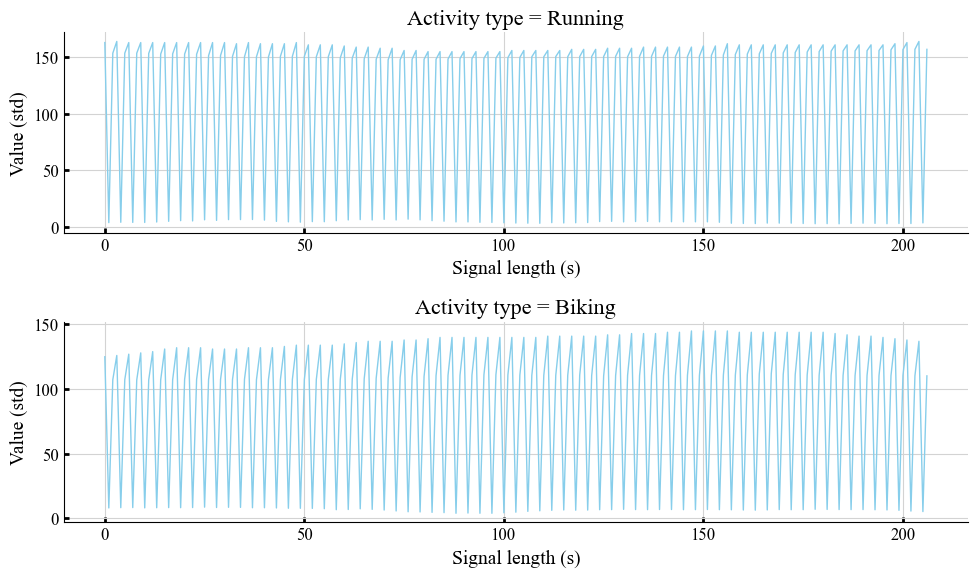

In [21]:
fig, ax = plt.subplots(2,1,figsize=(10,6))
sns.lineplot(x_train[16], ax=ax[0])
ax[0].set_xlabel('Signal length (s)')
ax[0].set_ylabel('Value (std)')
ax[0].set_title("Activity type = %s" % SPORT_CODES[y_train[16]])
ax[0].grid()

sns.lineplot(x_test[7], ax=ax[1])
ax[1].set_xlabel('Signal length (s)')
ax[1].set_ylabel('Value (std)')
ax[1].set_title("Activity type = %s" % SPORT_CODES[y_test[7]])
ax[1].grid()

plt.tight_layout()

---

<a id="22"></a> <br>
### [▲](#2) 2B - Data Standardization *(for visualization)*

- Data can be standardized using **create_dataset(** *std=True* **)** function parameter
- This section procedure has precondition that **x_train** and **x_test** data is in two dimensional space

In [22]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_train_std = scaler.fit_transform(x_train)
x_test_std = scaler.fit_transform(x_test)

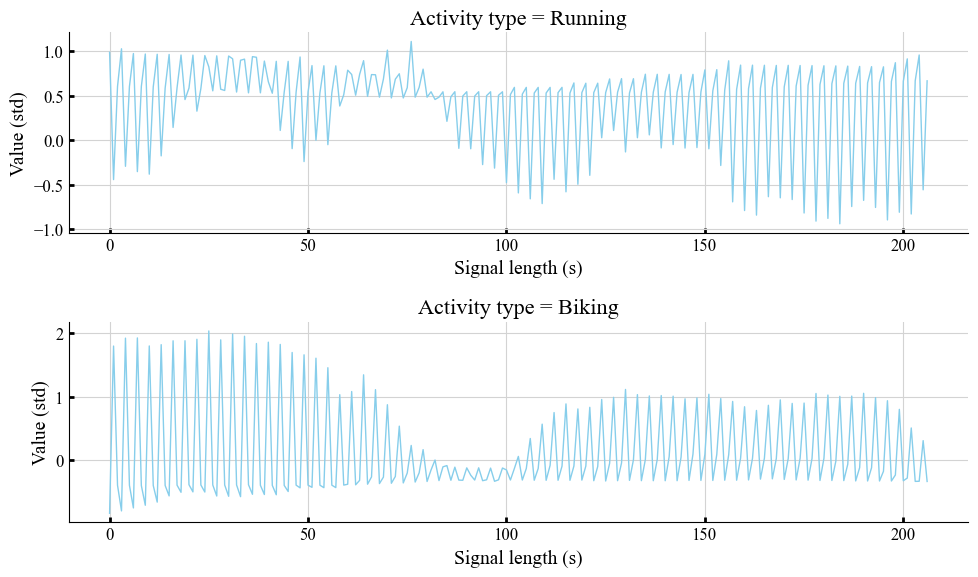

In [23]:
fig, ax = plt.subplots(2,1,figsize=(10,6))
sns.lineplot(x_train_std[16], ax=ax[0])
ax[0].set_xlabel('Signal length (s)')
ax[0].set_ylabel('Value (std)')
ax[0].set_title("Activity type = %s" % SPORT_CODES[y_train[16]])
ax[0].grid()

sns.lineplot(x_test_std[7], ax=ax[1])
ax[1].set_xlabel('Signal length (s)')
ax[1].set_ylabel('Value (std)')
ax[1].set_title("Activity type = %s" % SPORT_CODES[y_test[7]])
ax[1].grid()

plt.tight_layout()

Let's visualize the effect of standardization

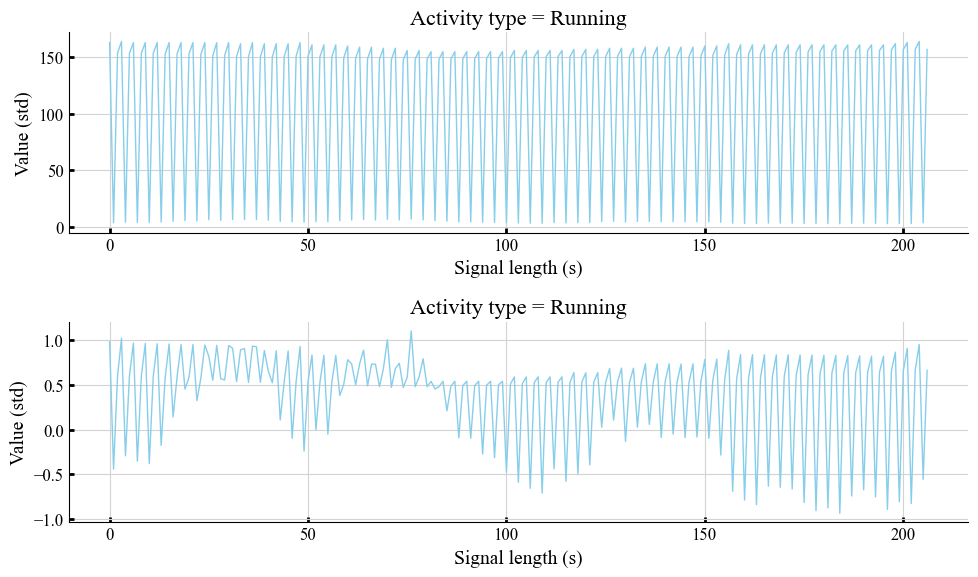

In [24]:
fig, ax = plt.subplots(2,1,figsize=(10,6))
sns.lineplot(x_train[16], ax=ax[0])
ax[0].set_xlabel('Signal length (s)')
ax[0].set_ylabel('Value (std)')
ax[0].set_title("Activity type = %s" % SPORT_CODES[y_train[16]])
ax[0].grid()

sns.lineplot(x_train_std[16], ax=ax[1])
ax[1].set_xlabel('Signal length (s)')
ax[1].set_ylabel('Value (std)')
ax[1].set_title("Activity type = %s" % SPORT_CODES[y_train[16]])
ax[1].grid()

plt.tight_layout()

In [25]:
label1 = x_train_std[np.where(y_train==0)]
label2 = x_train_std[np.where(y_train==1)]
label3 = x_train_std[np.where(y_train==2)]

print(len(label1), len(label2), len(label3))

196 436 296


In [26]:
# Or without indexes
pd.DataFrame(y_train.astype(int)).value_counts()

1    436
2    296
0    196
dtype: int64

**Random activities (for each category)**

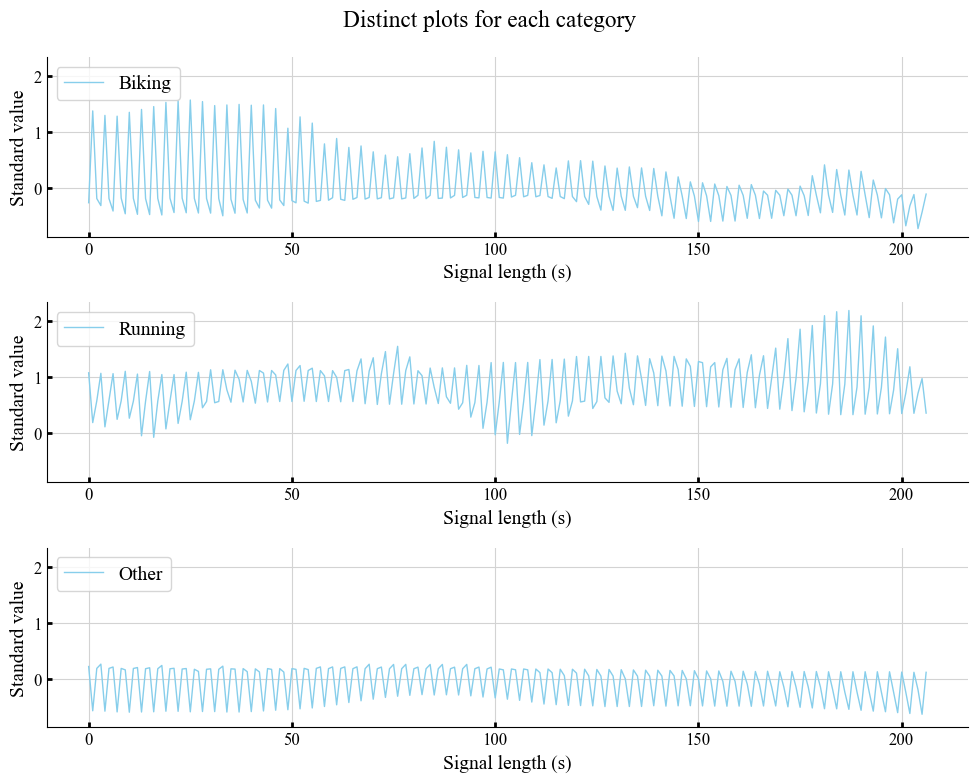

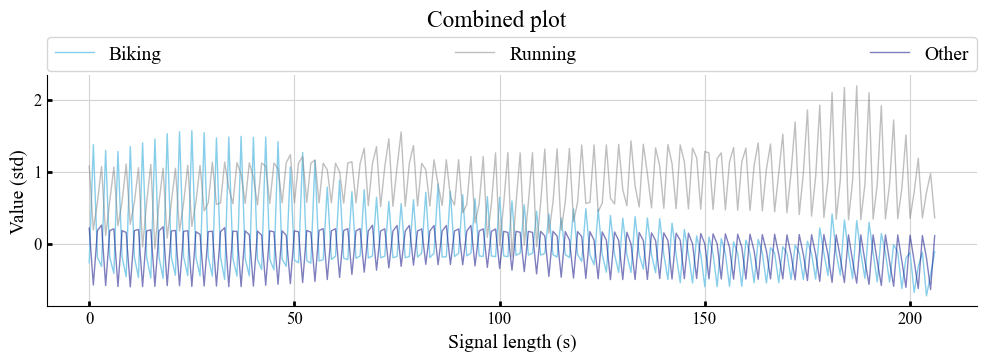

In [27]:
#@title { run: "auto" }
rand_index = 32 #@param {type:"slider", min:0, max:42, step:1}

fig, ax = plt.subplots(3,1, figsize=(10,8), sharey=True)
fig.suptitle('Distinct plots for each category')
ax[0].plot(label1[rand_index], label='Biking')
ax[0].legend(loc='upper left', bbox_to_anchor=(0, 1))
ax[0].grid()
ax[1].plot(label2[rand_index], label='Running')
ax[1].legend(loc='upper left', bbox_to_anchor=(0, 1))
ax[1].grid()
ax[2].plot(label3[rand_index], label='Other')
ax[2].legend(loc='upper left', bbox_to_anchor=(0, 1))
ax[2].grid()
# Set common labels
plt.setp(ax, ylabel='Standard value')
plt.setp(ax, xlabel='Signal length (s)')
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(1,1,figsize=(12,3))
fig.suptitle('Combined plot', y=1.1)
ax.plot(label1[rand_index], label='Biking')
ax.plot(label2[rand_index], label='Running', c='grey', alpha=0.5)
ax.plot(label3[rand_index], label='Other', c='navy', alpha=0.5)
ax.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left',
                      ncol=3, mode="expand", borderaxespad=0.)
plt.xlabel('Signal length (s)')
plt.ylabel('Value (std)')
plt.grid()
plt.show()

**Random activities (for same category)**

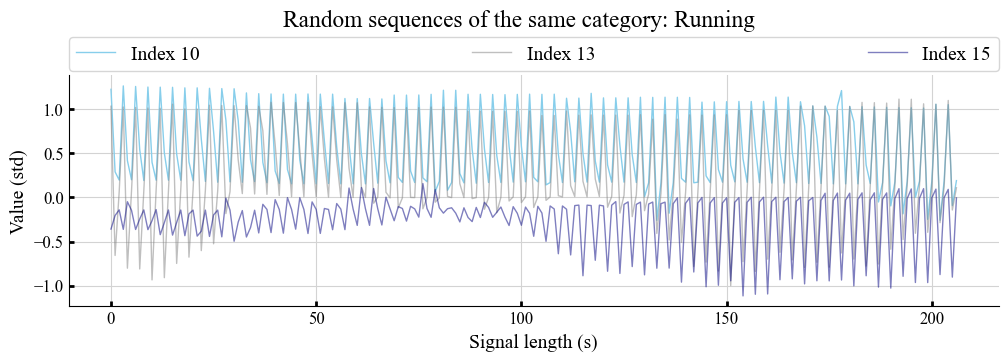

In [28]:
#@title { run: "auto" }
rand_index1 = 10 #@param {type:"slider", min:0, max:42, step:1}
rand_index2 = 13 #@param {type:"slider", min:0, max:42, step:1}
rand_index3 = 15 #@param {type:"slider", min:0, max:42, step:1}
label = label2 #@param ["label1", "label2", "label3"] {type: "raw"}


plt.figure(figsize=(12,3))
plt.suptitle("Random sequences of the same category: Running", y=1.1)
plt.plot(label[rand_index1], lw=1, label='Index ' + str(rand_index1))
plt.plot(label[rand_index2], lw=1, label='Index ' + str(rand_index2), c='grey', alpha=0.5)
plt.plot(label[rand_index3], lw=1, label='Index ' + str(rand_index3), c='navy', alpha=0.5)
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left',
                      ncol=3, mode="expand", borderaxespad=0.)
plt.xlabel('Signal length (s)')
plt.ylabel('Value (std)')
plt.grid()
plt.show()

---

<a id="3"></a> <br>
## [▲](#0) 3 - Univariate Time Series Classification (UTSC)

Sktime model list
- [X] Time Series Forest Classifier
- [X] Supervised Time Series Forest
- [X] Random Interval Spectral Ensemble
- [X] Random Interval Classifier
- [X] Shapelet Transform Classifier
- [X] KNeighbors Time Series Classifier
- [X] Composable Time Series Forest Classifier
- [X] WEASEL
- [X] HIVE-COTEv1.0

<a id="31"></a> <br>
### [▲](#3) 3A - Libraries and functions

In [29]:
# Sktime univariate classifiers
from sktime.classification.interval_based import TimeSeriesForestClassifier
from sktime.classification.interval_based import SupervisedTimeSeriesForest
from sktime.classification.interval_based import RandomIntervalSpectralEnsemble # RISE
from sktime.classification.feature_based import RandomIntervalClassifier        # Rotation Forest
from sktime.classification.compose import ComposableTimeSeriesForestClassifier
from sktime.classification.shapelet_based import ShapeletTransformClassifier
from sktime.classification.distance_based import KNeighborsTimeSeriesClassifier
from sktime.classification.hybrid import HIVECOTEV1
from sktime.classification.dictionary_based import WEASEL

# Sktime - Multivariate
from sktime.classification.dictionary_based import MUSE

# Metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, mean_squared_error

# Time and Progress bar solution (tqdm)
from time import time
from tqdm import tqdm

# Extra tools
from matplotlib import gridspec

**Helper functions and variables**

In [30]:
def plot_confmatrix(ax, yval, ypred):
    cm = pd.DataFrame(confusion_matrix(yval, ypred))
    cm_norm = cm.apply(lambda x: x/x.sum(), axis = 1)
    sns.set(font_scale=1.1) # for label size
    sns.heatmap(cm_norm, annot=True, xticklabels=('Biking', 'Running','Other'), 
                                     yticklabels=('Biking', 'Running','Other'),
                                     fmt='.1%',
                                     cmap='Blues',
                                     ax=ax,
                                     annot_kws={"size": 16}) # font size

In [31]:
# Classification report properties for matplotlip.table
col_colors = ['lightgray','lightgray','lightgray','skyblue','skyblue','skyblue']
row_colors = ['lightgray','lightgray','lightgray','lightgray']
cell_colors = [['white','white','white','lightgray','white','white'],
               ['white','white','white','lightgray','white','white'],
               ['white','white','white','lightgray','white','white'],
               ['white','white','white','lightgray','white','white']]

In [32]:
'''
Creates list of column names according to the parameters
- @general: Start of the column name
- @num: Identification number for column
Output for function call create_col_names(general='Score', num=3) 
=> ['Score 1','Score 2', 'Score 3']
'''
def create_col_names(general, num, info=False):
    col_names = []
    for i in range(1,num+1):
        col_names.append(general + str(i))
    
    if info: print("Columns created: ", col_names)
    
    return col_names

In [33]:
'''
Saves data to the latest file in a given directory. 
Inserts a row to a classification result table or a column to a prediction result table.
Return the saved data back (data parameter passed in function call).

Expected parameter values:
- type = ['results','predictions'] - this will define to which actual file (path and filename) data will be inserted
- classifier = The name (appreviation) of the classifier as it appears in the column name of the data given as parameter
- data = pandas dataframe object. For type='results' assumed to be one row, and for type='predictions' one column.

NOTE: Function uses global file paths defined in *1B - Data download* -section
'''
def save_to_file(type:str, classifier:str, data:pd.DataFrame):
    
    if type == 'results':
        results_csv_filename = os.listdir(results_filepath)[-1]
        results_temp = pd.read_csv(results_filepath + results_csv_filename)
        results_temp = pd.concat((results_temp, data), axis=0, ignore_index=True)
        results_temp.to_csv(results_filepath + results_csv_filename, index=False)
        print('Results saved into file: ' + results_csv_filename)
        
    elif type == 'predictions':
        preds_csv_filename = os.listdir(preds_filepath)[-1]
        preds_temp = pd.read_csv(preds_filepath + preds_csv_filename)
        preds_temp[classifier] = data[classifier]
        preds_temp.to_csv(preds_filepath + preds_csv_filename, index=False)
        print('Predictions saved into file: ' + preds_csv_filename)
    
    return data

**Classification functions**

In [34]:
'''
This classification funtion takes models and data as a function parameters ans prints out the results.
Notice, that results are only printed immediately when classification is completed, but nothing is stored. 
Therefore, when execution fails all the data will be lost. Be careful!
'''
def classify_report(models, x_train, y_train, x_test, y_test):
    for name, sktime_clf in models.items():
        # Classify
        clf = sktime_clf 
        clf.fit(x_train, y_train)
        y_pred = clf.predict(x_test)
        print(name, accuracy_score(y_test, y_pred))
        # Create figure and grid for different subplots
        fig = plt.figure(figsize=(18,3))
        spec = gridspec.GridSpec(ncols=2, nrows=1, width_ratios=[1, 2], wspace=0.3)
        # Plot confusion matrix
        ax1 = fig.add_subplot(spec[0])
        plot_confmatrix(ax1, y_test, y_pred)
        ax1.set_xlabel('Predicted')
        ax1.set_ylabel('Actual')
        # Plot classification report
        report = pd.DataFrame(classification_report(y_test, y_pred, digits=3, output_dict=True))
        ax2 = fig.add_subplot(spec[1])
        font_size=16
        bbox=[0, 0, 1, 1]
        ax2.axis('off')
        mpl_table = ax2.table(cellText=np.round(report.values,4), 
                            rowLabels=report.index, bbox=bbox, 
                            colLabels=report.columns,
                            colColours=col_colors,
                            rowColours=row_colors,
                            cellColours=cell_colors,
                            edges='closed')
        mpl_table.auto_set_font_size(False)
        mpl_table.set_fontsize(font_size)
        plt.show()

In [35]:
'''
Classification function which creates result tables. However, it does not create or print out any kind of analysis, 
such as correlation matrixes etc.
Data given as parameters have to be according to the classifier's requirements. 
Usability for different type of classifiers is quite flexible. 
Remember to use correct classifier type name from the list
clf_type = sktime | sklearn | sklearn-tree
'''
def classify(classifiers, clf_type, X_train, X_test, y_train, y_test, results, preds, iters):
    # Pandas dataframe for results
    if results is None:
        results = pd.DataFrame(columns=['Classifier','Type','Train(t)','Test(t)'])
        preds = pd.DataFrame()
    
    # Create column names for scores according to the number of iterations
    score_col_names = create_col_names('Score_', iters)
    
    # Create progress bar with non-default styles
    progress_bar = tqdm(classifiers.items(), ncols=100, colour='#87ceeb', file=sys.stdout)
    
    for name, clf in progress_bar:
        progress_bar.set_description("Processing \033[1m ➥%s \033[0m" % str(clf)) # Includes bold text printing
        score_row = pd.DataFrame(data={'Classifier': name,'Type': clf_type,}, index=[0])
        
        # Insert score colums for each iterations
        for i in range(1,iters+1):
            score_row[score_col_names] = 0
        
        best_score = 0

        for iter in range(1,iters+1):
            start = time() # Start timing the model
            clf.fit(X_train, y_train)
            train_time = time() - start # Stop train timer
            start = time()              # Start test timer
            # Predictions
            y_pred = clf.predict(X_test)
            # Model scores
            score = accuracy_score(y_test, y_pred)
            score_time = time()-start
            # Set values (note: time data will be overwritten in each iteration)
            score_row['Train(t)'] = train_time
            score_row['Test(t)'] = score_time
            score_row[score_col_names[iter-1]] = score
            # Among iterations, we could take only one mse, f1 and roc. We store them for the best accuracy.
            if score > best_score:
                # STORE PREDICTIONS to a data frame
                preds[name] = y_pred
                # More metrics: MSE, F1 and ROC-AUC scores
                score_row['mse'] = mean_squared_error(y_test, y_pred)
                score_row['f1'] = f1_score(y_test, y_pred, average='micro')
                if clf_type not in ['sklearn']:
                    y_pred_proba = clf.predict_proba(X_test)
                    score_row['roc-auc'] = roc_auc_score(y_test, y_pred_proba, average="weighted", multi_class="ovr")
                else:
                    score_row['roc-auc'] = np.nan
                best_score = score
            
        results = pd.concat((results, score_row), axis=0, ignore_index=True)
        
    print('Classification done for ' + clf_type + '\n')
    
    return results, preds

---

<a id="32"></a> <br>
### [▲](#3) 3B - Data setup

Here we initialize global variables 
`x_data_std, y_data, x_train_std, x_test_std, y_train, y_test` using function `init_data(...)`

In [36]:
init_data(SEQ_START, SEQ_END, nest=True, tab=True, std=True)

X: (1160, 207)  y: (1160,)
Train: (928, 207) (928,) Test: (232, 207) (232,)
X: (1160, 207)  y: (1160,)
Train: (928, 207) (928,) Test: (232, 207) (232,)


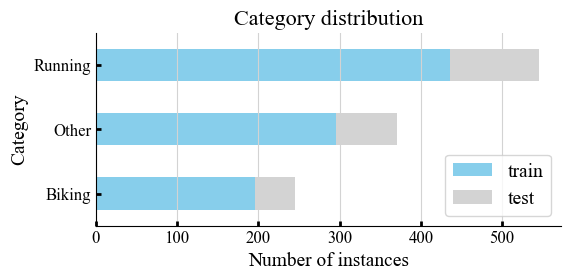

In [37]:
# Create data to count category distribution in train and test data
y_train_labels = pd.DataFrame(y_train.astype(int), columns=['cat'])
y_train_labels.cat.replace(SPORT_CODES.keys(), SPORT_CODES.values(), inplace=True)
y_train_labels['split'] = 'train'
y_test_labels = pd.DataFrame(y_test.astype(int), columns=['cat'])
y_test_labels.cat.replace(SPORT_CODES.keys(), SPORT_CODES.values(), inplace=True)
y_test_labels['split'] = 'test'
cat_distribut_tbl = pd.concat([y_train_labels, y_test_labels])
cat_distribut_tbl = cat_distribut_tbl.groupby(['cat', 'split'])['cat'].count().unstack('split')
cat_distribut_tbl = cat_distribut_tbl.reindex(columns=['train','test']) # Have to change column order for plot

# Plot dataframe
fig, ax = plt.subplots(1,1,figsize=(6,2.5))
cat_distribut_tbl.plot(kind='barh',
                       stacked=True,
                       width=0.5,
                       title='Category distribution',
                       #color=[THEMA_COLOR, 'skyblue'],
                       grid=True,
                       ax=ax).legend(loc='lower right')
plt.xlabel('Number of instances')
plt.ylabel('Category')
plt.grid(axis='y')

#### Signal visualization in test data

In [38]:
labels, counts = np.unique(y_test, return_counts=True)
print(labels, counts)

[0. 1. 2.] [ 49 109  74]


In [39]:
X_test_nest_std.rename(columns={0:'dim_0'}).head() # For report we change the column name temporarily

dim_0
0  0      1.144134
1      0.568327
2      0.42319...
1  0     -1.127033
1      0.596525
2     -0.58755...
2  0      0.805875
1     -0.348132
2      0.19524...
3  0     -0.643806
1      0.526029
2     -0.05422...
4  0      1.627362
1      0.008884
2      0.20384...

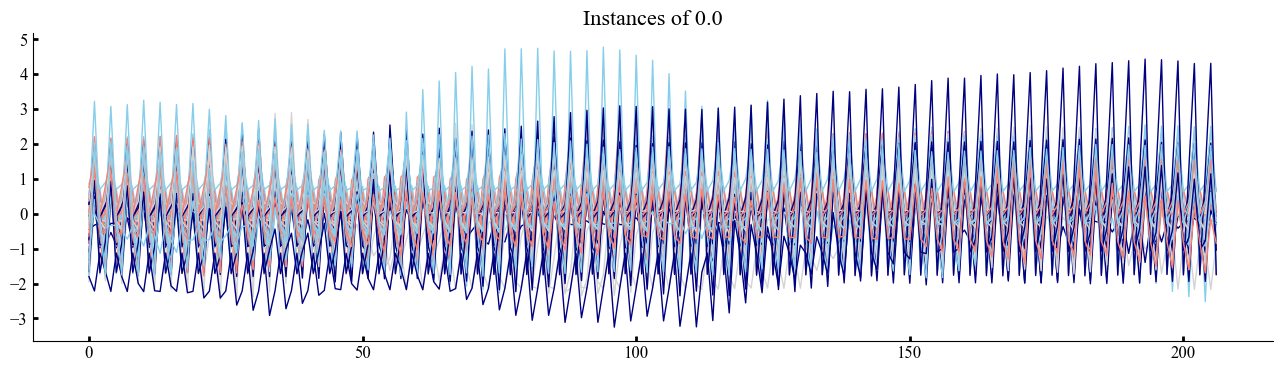

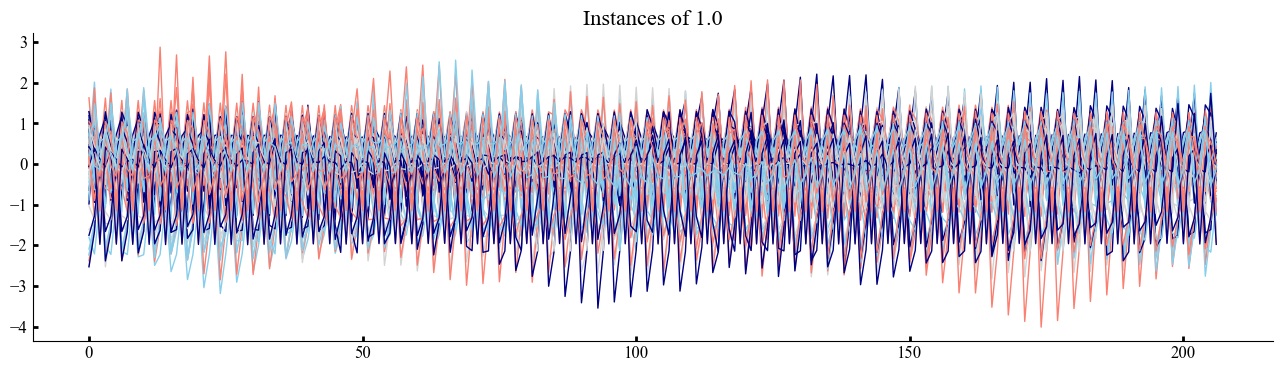

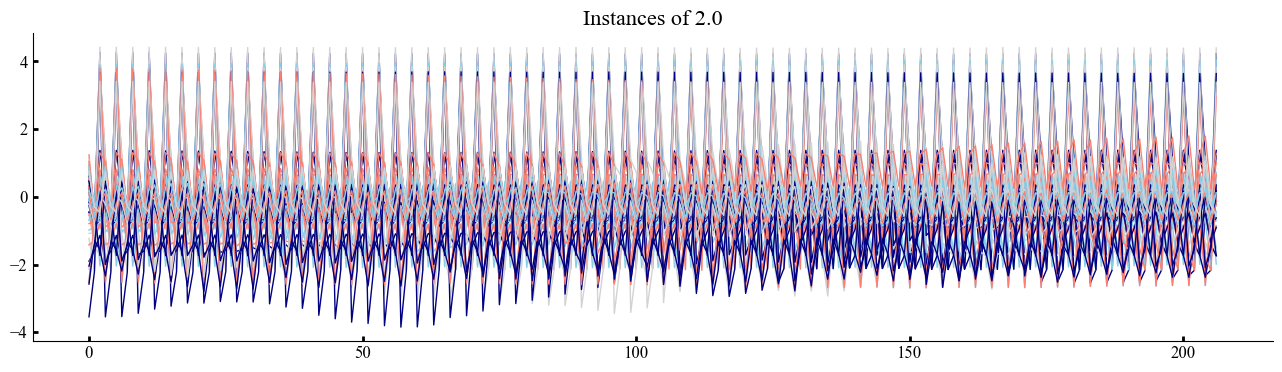

In [40]:
for label in labels:
    fig, ax = plt.subplots(1, figsize=plt.figaspect(0.25))
    for instance in X_test_nest_std.loc[y_test==label, 0]:
        ax.plot(instance, label='label')
    ax.set(title=f"Instances of {label}")

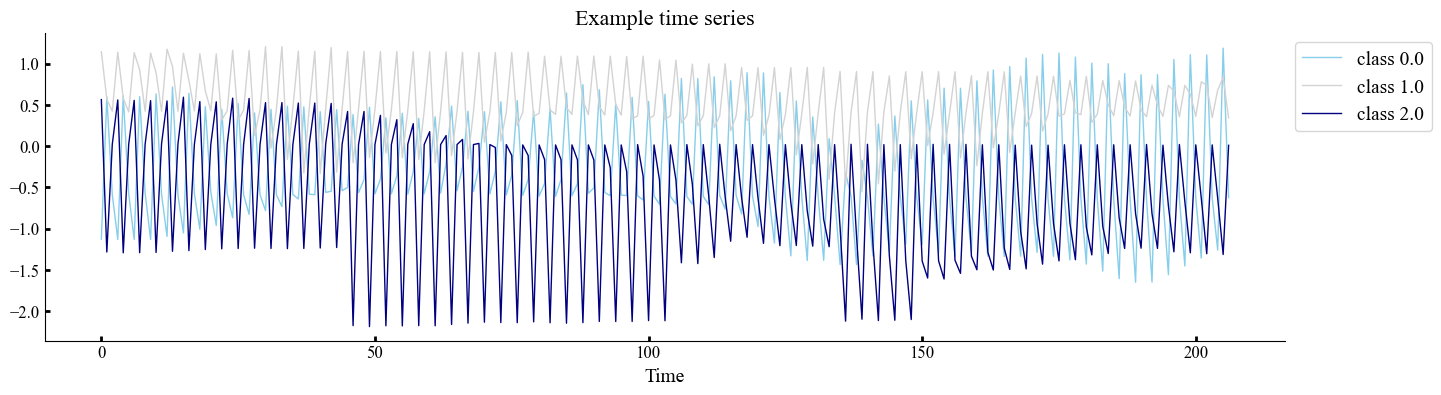

In [41]:
fig, ax = plt.subplots(1, figsize=plt.figaspect(0.25))
for label in labels:
    X_test_nest_std.loc[y_test==label, 0].iloc[0].plot(ax=ax, label=f"class {label}")
plt.legend(loc='upper left', bbox_to_anchor=(1,1))
ax.set(title="Example time series", xlabel="Time");

---

<a id="33"></a> <br>
### [▲](#3) 3C - Univariate TSC model classification

#### Sktime models

In [49]:
sktime_clfs = {
    'TSF': TimeSeriesForestClassifier(),
    'STSF': SupervisedTimeSeriesForest(),
    'RISE': RandomIntervalSpectralEnsemble(),
    'RIC': RandomIntervalClassifier(),
    'STC': ShapeletTransformClassifier(),
    'kNN-TS': KNeighborsTimeSeriesClassifier(),
    'CTSF': ComposableTimeSeriesForestClassifier(), # Time consuming (~30-40min)
    'WEASEL': WEASEL(support_probabilities=True),
    #'HIVE-COTEv1.0': HIVECOTEV1(),                                                 # Extreme time consuming (one succesful run in 900min=15h)
    #'CanonicalIntervalForest': CanonicalIntervalForest(),                          # Extreme time consuming
}

#### Classification with modelwise reports (Disabled)

In [43]:
#classify_report(sktime_clfs, X_train_nest_std, y_train, X_test_nest_std, y_test)
# This is HIVE-COTE result

#### Single models test (Disabled)

**TEST** TSF EXTRA

In [44]:
#clf_tsf = TimeSeriesForestClassifier()
#classify_report({'TSF':clf_tsf}, X_train_nest_std, y_train, X_test_nest_std, y_test)

**TEST** HIVECOTE EXTRA

In [45]:
# This took time 900 min
#sktime_clfs_e1 = {'HIVE-COTE': HIVECOTEV1()}
#classify_report(sktime_clfs_e1, X_train_nest_std, y_train, X_test_nest_std, y_test)

![hive_cote_report](./img/classification_report_hivecote1.png)

**TEST** WEASEL EXTRA

In [46]:
#sktime_clfs_e2 = {'WEASEL': WEASEL()}
#classify_report(sktime_clfs_e2, X_train_nest_std, y_train, X_test_nest_std, y_test)

#### Iterative Classification

In [50]:
init_data(SEQ_START, SEQ_END, nest=True, tab=True, std=True)

X: (1160, 207)  y: (1160,)
Train: (928, 207) (928,) Test: (232, 207) (232,)
X: (1160, 207)  y: (1160,)
Train: (928, 207) (928,) Test: (232, 207) (232,)


<div style="display: flex; padding: 15px; background-color: skyblue; height: 60px; border-radius: 5px; width: 95vw;">
    <h3 style="font-size: 20px;"><b>Classify</b> - Data setup B</h3><br>
</div>

In [51]:
ITERS = 3
#Please Note, this may take time about ~20 min per iteration with ~500 features
results, preds = classify(sktime_clfs, 'sktime', X_train_nest_std, X_test_nest_std, y_train, y_test, results=None, preds=None, iters=ITERS)

Processing  ➥WEASEL(support_probabilities=True) :  88%|██████████▌ | 7/8 [1:28:56<12:28, 748.33s/it]

c:\Users\jarno\anaconda3\envs\dw\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\jarno\anaconda3\envs\dw\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\jarno\anaconda3\envs\dw\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Processing  ➥WEASEL(support_probabilities=True) : 100%|████████████| 8/8 [1:31:28<00:00, 686.11s/it]
Classification done for sktime



**Check the data before saving**

In [52]:
results.sort_values('Score_1') 

Classifier    Type    Train(t)    Test(t)   Score_1   Score_2   Score_3  \
5     kNN-TS  sktime    1.762350  70.616180  0.771552  0.771552  0.771552   
7     WEASEL  sktime   48.854611   1.243615  0.879310  0.883621  0.883621   
0        TSF  sktime   21.725066   1.831053  0.883621  0.879310  0.909483   
6       CTSF  sktime   39.486590   2.172076  0.883621  0.879310  0.879310   
4        STC  sktime  777.304973  19.428540  0.887931  0.892241  0.883621   
2       RISE  sktime  108.982532  11.933838  0.900862  0.896552  0.896552   
3        RIC  sktime  518.393395  34.493988  0.913793  0.939655  0.913793   
1       STSF  sktime   76.383772   4.405586  0.922414  0.926724  0.926724   

        mse        f1   roc-auc  
5  0.357759  0.771552  0.828858  
7  0.245690  0.883621  0.959994  
0  0.103448  0.909483  0.975598  
6  0.116379  0.883621  0.974591  
4  0.133621  0.892241  0.973338  
2  0.202586  0.900862  0.979886  
3  0.086207  0.939655  0.989568  
1  0.099138  0.926724  0.989003

In [53]:
preds

TSF  STSF  RISE  RIC  STC  kNN-TS  CTSF  WEASEL
0    1.0   1.0   1.0  1.0  1.0     1.0   1.0     1.0
1    0.0   0.0   1.0  0.0  0.0     2.0   0.0     0.0
2    1.0   1.0   1.0  1.0  1.0     1.0   1.0     1.0
3    1.0   1.0   1.0  1.0  1.0     1.0   1.0     0.0
4    1.0   1.0   1.0  1.0  1.0     1.0   1.0     1.0
..   ...   ...   ...  ...  ...     ...   ...     ...
227  1.0   2.0   2.0  2.0  2.0     2.0   1.0     2.0
228  0.0   0.0   1.0  0.0  0.0     2.0   0.0     0.0
229  1.0   1.0   1.0  1.0  1.0     1.0   1.0     1.0
230  0.0   0.0   0.0  0.0  0.0     0.0   0.0     0.0
231  1.0   1.0   1.0  1.0  1.0     1.0   1.0     1.0

[232 rows x 8 columns]

**Save results, scores and predictions to the file**

In [54]:
time_stamp = datetime.datetime.now().strftime("D%Y%m%d_T%H%M")
results_csv_filename = 'results_datasetup_b_' + time_stamp + '.csv'
preds_csv_filename = 'preds_datasetup_b_' + time_stamp + '.csv'

In [55]:
results.to_csv(results_filepath + results_csv_filename, index=False)
preds.to_csv(preds_filepath + preds_csv_filename, index=False)

**Save the case data** 

* This is for later analysis (every time different test data)
* This must be done before `init_data()`function call in order to maintain the same CASE-data which was used in the classification

In [56]:
case_data_train = pd.DataFrame(np.column_stack((x_train_std, y_train)))
case_data_train.to_csv('DATA/case_data/TRAIN-DATA_CASE-' + time_stamp, index=False)

In [57]:
case_data_test = pd.DataFrame(np.column_stack((x_test_std, y_test)))
case_data_test.to_csv('DATA/case_data/TEST-DATA_CASE-' + time_stamp, index=False)

#### Manual TSC classification (Disabled)

* Here you can try classification with a single model (or smaller subset of classifiers) using the same functions
* You can insert results to existing saved tables using *read-modify-save* method

In [58]:
#init_data(SEQ_START, SEQ_END, nest=True, tab=True, std=True)

Current model: cBOSS

In [59]:
#from sktime.classification.dictionary_based import ContractableBOSS

In [60]:
'''
ITERS = 1
sktime_clfs_e2 = {'cBOSS': ContractableBOSS()}
results_cboss, preds_cboss = classify(sktime_clfs_e2, 'sktime', X_train_nest_std, X_test_nest_std, y_train, y_test, results=None, preds=None, iters=ITERS)
'''

"\nITERS = 1\nsktime_clfs_e2 = {'cBOSS': ContractableBOSS()}\nresults_cboss, preds_cboss = classify(sktime_clfs_e2, 'sktime', X_train_nest_std, X_test_nest_std, y_train, y_test, results=None, preds=None, iters=ITERS)\n"

In [61]:
#results_cboss

Reads latest predictions from the existing file and inserts a new prediction column to the table. Then file will be saved again.

In [62]:
'''
preds_csv_filename = os.listdir(preds_filepath)[-1]
preds_csv_filename
'''

'\npreds_csv_filename = os.listdir(preds_filepath)[-1]\npreds_csv_filename\n'

In [63]:
'''
preds_temp = pd.read_csv(preds_filepath + preds_csv_filename)
preds_temp['cBOSS'] = preds.cBOSS
preds_temp['Correct'] = y_test
preds_temp.to_csv(preds_filepath + preds_csv_filename, index=False)
'''

"\npreds_temp = pd.read_csv(preds_filepath + preds_csv_filename)\npreds_temp['cBOSS'] = preds.cBOSS\npreds_temp['Correct'] = y_test\npreds_temp.to_csv(preds_filepath + preds_csv_filename, index=False)\n"

#### ROC-AUC -curve analysis for TSF

For practical reason we do this here for now

In [64]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import RocCurveDisplay, roc_auc_score

In [65]:
train_data = pd.read_csv('DATA/case_data/TRAIN-DATA_CASE-D20230424_T1718')
test_data = pd.read_csv('DATA/case_data/TEST-DATA_CASE-D20230424_T1718')

In [66]:
x_train = train_data.iloc[:,:-1].values
y_train = train_data['207']
x_test = test_data.iloc[:,:-1].values
y_test = test_data['207']

In [67]:
sktime_clfs

{'TSF': TimeSeriesForestClassifier(),
 'STSF': SupervisedTimeSeriesForest(),
 'RISE': RandomIntervalSpectralEnsemble(),
 'RIC': RandomIntervalClassifier(),
 'STC': ShapeletTransformClassifier(),
 'kNN-TS': KNeighborsTimeSeriesClassifier(),
 'CTSF': ComposableTimeSeriesForestClassifier(),
 'WEASEL': WEASEL(support_probabilities=True)}

In [68]:
sktime_clfs.get('TSF').fit(x_train, y_train)

TimeSeriesForestClassifier()

In [69]:
#sktime_clfs.get('TSF').predict(x_test)
y_score = sktime_clfs.get('TSF').predict_proba(x_test)

In this section we use a LabelBinarizer to binarize the target by one-hot-encoding in a OvR fashion. This means that the target of shape (n_samples,) is mapped to a target of shape (n_samples, n_classes).

In [70]:
label_binarizer = LabelBinarizer().fit(y_train)
y_onehot_test = label_binarizer.transform(y_test)
y_onehot_test.shape  # (n_samples, n_classes)

(232, 3)

We can as well easily check the encoding of a specific class:

In [71]:
label_binarizer.transform([1])

array([[0, 1, 0]])

ROC curve showing a specific class

- In the following plot we show the resulting ROC curve when regarding the sports as either “biking” (class_id=0) or “non-biking” (the rest 1 or 2).

In [72]:
class_of_interest = 0
class_id = np.flatnonzero(label_binarizer.classes_ == class_of_interest)[0]
class_id

0

0.978653009914905


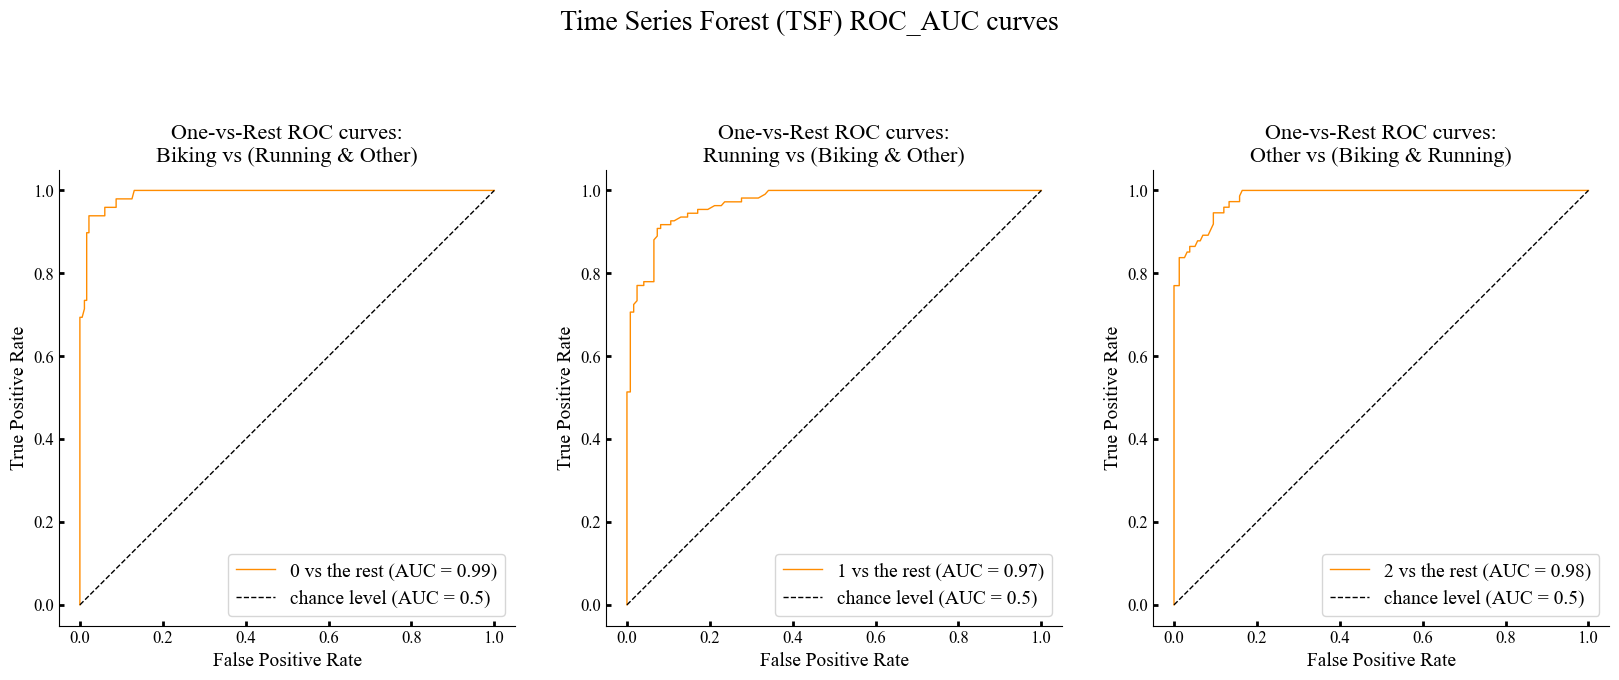

In [73]:
# Print roc-auc using sklearn function
print(roc_auc_score(y_test, y_score, average="weighted", multi_class="ovr"))
one_vs_rest_pairs = [('Biking','Running & Other'),('Running','Biking & Other'),('Other','Biking & Running')]

fig, ax = plt.subplots(1,3,figsize=(20,8))

for f in [0,1,2]:

    class_of_interest = f
    class_id = np.flatnonzero(label_binarizer.classes_ == class_of_interest)[0]

    RocCurveDisplay.from_predictions(
        y_onehot_test[:, class_id],
        y_score[:, class_id],
        name=f"{class_of_interest} vs the rest",
        color="darkorange",
        ax=ax[f]
    )
    ax[f].plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
    ax[f].axis("square")
    ax[f].set_xlabel("False Positive Rate")
    ax[f].set_ylabel("True Positive Rate")
    ax[f].set_title(f'One-vs-Rest ROC curves:\n%s vs (%s)' % one_vs_rest_pairs[f])
    ax[f].legend()

fig.suptitle('Time Series Forest (TSF) ROC_AUC curves', fontsize=20)
plt.show()

---

<a id="4"></a> <br>
## [▲](#0) 4 - Multivariate TSC (MTSC)

<a id="41"></a> <br>
### [▲](#4) 4A - Libraries and functions

In [74]:
from sktime.classification.dictionary_based import MUSE # WEASEL+MUSE (multivariate version of WEASEL)
from sktime.classification.compose import ColumnEnsembleClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from sktime.datatypes._panel._convert import from_2d_array_to_nested

---

<a id="42"></a> <br>
### [▲](#4) 4B - Data setup

In [75]:
hr_list = np.array([seq.T[0] for seq in SEQ_SEGMENTED])
spd_list = np.array([seq.T[1] for seq in SEQ_SEGMENTED])
alt_list = np.array([seq.T[2] for seq in SEQ_SEGMENTED])

hr_std = (hr_list - hr_list.mean())/(hr_list.std())
spd_std = (spd_list - spd_list.mean())/(spd_list.std())
alt_std = (alt_list - alt_list.mean())/(alt_list.std())

In [76]:
hr_std.shape

(1160, 69)

**Save data to file in order to access it later**

In [77]:
pd.DataFrame(hr_std).to_csv('DATA/HR-DATA_std_1160x69', index=False)
pd.DataFrame(spd_std).to_csv('DATA/SPD-DATA_std_1160x69', index=False)
pd.DataFrame(alt_std).to_csv('DATA/ALT-DATA_std_1160x69', index=False)
pd.DataFrame(SEQ_SEGMENTED_LABELS.label).to_csv('DATA/TARGET-DATA_1160x1', index=False)

**Segment visualization**

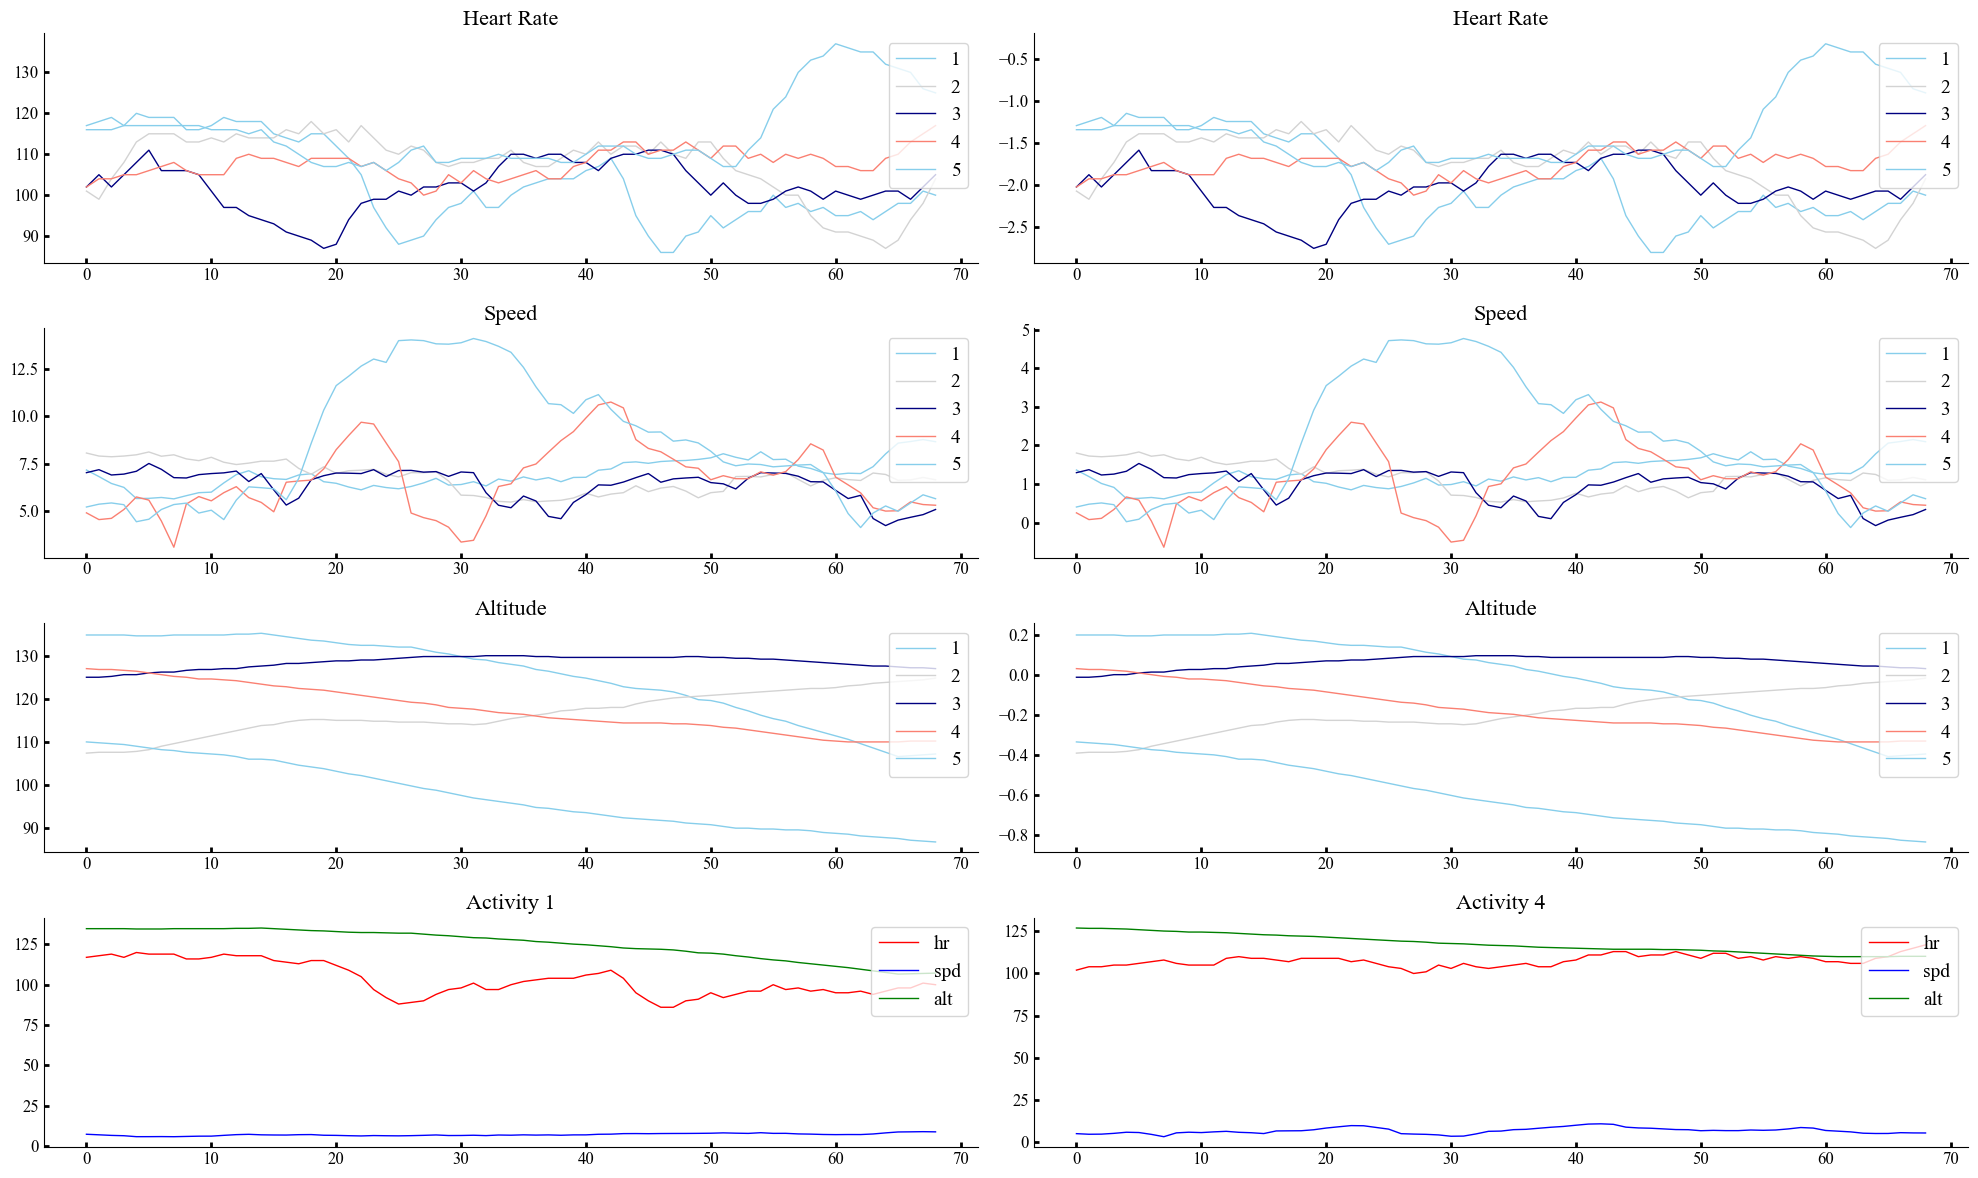

In [78]:
fig, ax = plt.subplots(4,2,figsize=(20,12))

def plot_sample(ax, data, title, legend=['1','2','3','4','5'], loc='upper right', color=None):
    ax.set_title(title)
    ax.plot(data, color=color)
    ax.legend(legend, loc=loc)

# Original data plots
plot_sample(ax[0,0], hr_list[0:5].T, 'Heart Rate')
plot_sample(ax[1,0], spd_list[0:5].T, 'Speed')
plot_sample(ax[2,0], alt_list[0:5].T, 'Altitude')

# Scaled data plots
plot_sample(ax[0,1], hr_std[0:5].T, 'Heart Rate')
plot_sample(ax[1,1], spd_std[0:5].T, 'Speed')
plot_sample(ax[2,1], alt_std[0:5].T, 'Altitude')

# Plot activity features
plot_sample(ax[3,0], hr_list[0], title='', color='red')
plot_sample(ax[3,0], spd_list[0], title='', color='blue')
plot_sample(ax[3,0], alt_list[0], title='Activity 1', legend=['hr','spd','alt'], color='green')

plot_sample(ax[3,1], hr_list[3], title='', color='red')
plot_sample(ax[3,1], spd_list[3], title='', color='blue')
plot_sample(ax[3,1], alt_list[3], title='Activity 4', legend=['hr','spd','alt'], color='green')

plt.tight_layout()
plt.show()

Effect of standardization

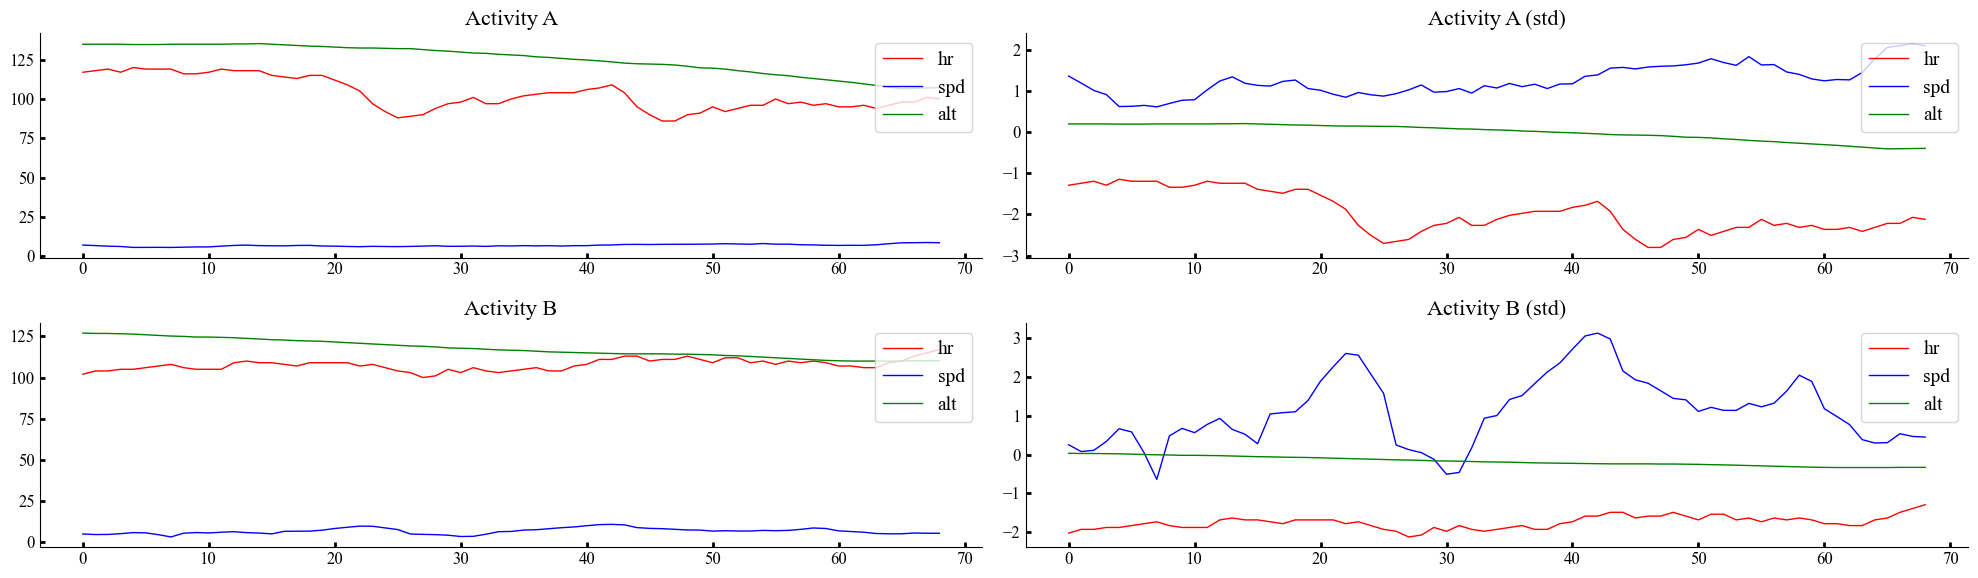

In [79]:
fig, ax = plt.subplots(2,2,figsize=(20,6))

# Plot activity features
ax[0,0].set_title('Activity A')
ax[0,0].plot(hr_list[0], color='red')
ax[0,0].plot(spd_list[0], color='blue')
ax[0,0].plot(alt_list[0], color='green')
ax[0,0].legend(['hr','spd','alt'], loc='upper right')

ax[0,1].set_title('Activity A (std)')
ax[0,1].plot(hr_std[0], color='red')
ax[0,1].plot(spd_std[0], color='blue')
ax[0,1].plot(alt_std[0], color='green')
ax[0,1].legend(['hr','spd','alt'], loc='upper right')

ax[1,0].set_title('Activity B')
ax[1,0].plot(hr_list[3], color='red')
ax[1,0].plot(spd_list[3], color='blue')
ax[1,0].plot(alt_list[3], color='green')
ax[1,0].legend(['hr','spd','alt'], loc='upper right')

ax[1,1].set_title('Activity B (std)')
ax[1,1].plot(hr_std[3], color='red')
ax[1,1].plot(spd_std[3], color='blue')
ax[1,1].plot(alt_std[3], color='green')
ax[1,1].legend(['hr','spd','alt'], loc='upper right')

plt.tight_layout()

Transform features separately to a nested structure

In [80]:
df_nest_hr = from_2d_array_to_nested(np.array(hr_std))
df_nest_spd = from_2d_array_to_nested(np.array(spd_std))
df_nest_alt = from_2d_array_to_nested(np.array(alt_std))

In [81]:
df_nest_hr

0
0     0    -1.291614
1    -1.242833
2    -1.194051
3...
1     0    -2.072115
1    -2.169677
2    -1.925771
3...
2     0    -2.023334
1    -1.876990
2    -2.023334
3...
3     0    -2.023334
1    -1.925771
2    -1.925771
3...
4     0    -1.340395
1    -1.340395
2    -1.340395
3...
...                                                 ...
1155  0    -2.608709
1    -2.608709
2    -2.559928
3...
1156  0    -2.169677
1    -2.023334
2    -1.974552
3...
1157  0    -0.267207
1    -0.267207
2    -0.218426
3...
1158  0     0.366950
1     0.318169
2     0.366950
3...
1159  0     0.415731
1     0.464513
2     0.464513
3...

[1160 rows x 1 columns]

In [82]:
df_multi = pd.DataFrame()
df_multi['hr'] = df_nest_hr
df_multi['spd'] = df_nest_spd
df_multi['alt'] = df_nest_alt
df_multi['target'] = SEQ_SEGMENTED_LABELS.label.astype('category')
df_multi

hr  \
0     0    -1.291614
1    -1.242833
2    -1.194051
3...   
1     0    -2.072115
1    -2.169677
2    -1.925771
3...   
2     0    -2.023334
1    -1.876990
2    -2.023334
3...   
3     0    -2.023334
1    -1.925771
2    -1.925771
3...   
4     0    -1.340395
1    -1.340395
2    -1.340395
3...   
...                                                 ...   
1155  0    -2.608709
1    -2.608709
2    -2.559928
3...   
1156  0    -2.169677
1    -2.023334
2    -1.974552
3...   
1157  0    -0.267207
1    -0.267207
2    -0.218426
3...   
1158  0     0.366950
1     0.318169
2     0.366950
3...   
1159  0     0.415731
1     0.464513
2     0.464513
3...   

                                                    spd  \
0     0     1.362796
1     1.192517
2     1.013872
3...   
1     0     1.803256
1     1.725499
2     1.706798
3...   
2     0     1.293897
1     1.371654
2     1.233856
3...   
3     0     0.251555
1     0.076847
2     0.108836
3...   
4     0     0.403133
1     0.476461
2     0.508450
3...   
...                                                 ...   
1155  0    -1.337548
1    -1.332627
2    -1.332627
3...   
1156  0    -1.117072
1    -1.121501
2    -1.126422
3...   
1157  0    -0.621000
1    -0.621000
2    -0.621000
3...   
1158  0    -0.446784
1    -0.451213
2    -0.460564
3...   
1159  0    -0.575231
1    -0.579660
2    -0.584582
3...   

                                                    alt   target  
0     0     0.199635
1     0.199635
2     0.199635
3...   Biking  
1     0    -0.390335
1    -0.386029
2    -0.386029
3...   Biking  
2     0    -0.011376
1    -0.011376
2    -0.007070
3...   Biking  
3     0     0.031687
1     0.027381
2     0.027381
3...   Biking  
4     0    -0.334353
1    -0.338659
2    -0.342965
3...   Biking  
...                                                 ...      ...  
1155  0     3.386335
1     3.386335
2     3.390642
3...  Running  
1156  0     3.416480
1     3.412174
2     3.412174
3...  Running  
1157  0     3.377723
1     3.382029
2     3.377723
3...  Running  
1158  0     3.382029
1     3.382029
2     3.386335
3...  Running  
1159  0     3.416480
1     3.420786
2     3.425093
3...  Running  

[1160 rows x 4 columns]

---

<a id="43"></a> <br>
### [▲](#4) 4C - Multivariate TSC model classification

> Create train/test splits

In [83]:
x_tr, x_te, y_tr, y_te = train_test_split(df_multi.iloc[:,0:3], 
                                          df_multi.iloc[:,3].cat.codes, 
                                          test_size=0.2, 
                                          random_state=24, 
                                          stratify=df_multi.iloc[:,3], 
                                          shuffle=True)

`class MUSE(anova=True, 
            variance=False, 
            bigrams=True, 
            window_inc=2, 
            alphabet_size=4, 
            use_first_order_differences=True, 
            feature_selection='chi2', 
            p_threshold=0.05, 
            support_probabilities=False, 
            n_jobs=1,  
            random_state=None)`

> Classification report

MUSE 0.9568965517241379


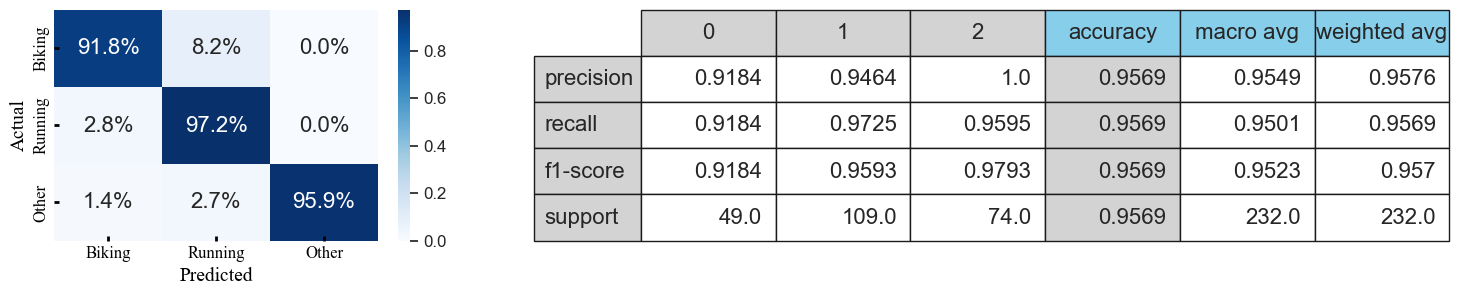

In [84]:
sktime_clfs_e3 = {'MUSE': MUSE(window_inc=4, support_probabilities=True)}
classify_report(sktime_clfs_e3, x_tr, y_tr, x_te, y_te)

> Iterative classification

TODO: Modify `classify()` function to allow probability calculation also for `sktime-multivariate` and `sktime-ensemble` types 

In [85]:
results_muse, preds_muse = classify(sktime_clfs_e3, 'sktime-multivar', x_tr, x_te, y_tr, y_te, results=None, preds=None, iters=3)

Processing  ➥MUSE(support_probabilities=True, window_inc=4) : 100%|██| 1/1 [02:02<00:00, 122.49s/it]
Classification done for sktime-multivar



In [86]:
results_muse

Classifier             Type  Train(t)   Test(t)   Score_1   Score_2  \
0       MUSE  sktime-multivar  38.40087  1.813703  0.965517  0.965517   

    Score_3       mse        f1   roc-auc  
0  0.961207  0.034483  0.965517  0.991771

In [87]:
preds_muse

MUSE
0       1
1       0
2       1
3       1
4       1
..    ...
227     2
228     0
229     1
230     0
231     1

[232 rows x 1 columns]

> Save results to file

In [88]:
save_to_file('results','MUSE',results_muse)

Results saved into file: results_datasetup_b_D20230504_T1944.csv


Classifier             Type  Train(t)   Test(t)   Score_1   Score_2  \
0       MUSE  sktime-multivar  38.40087  1.813703  0.965517  0.965517   

    Score_3       mse        f1   roc-auc  
0  0.961207  0.034483  0.965517  0.991771

In [89]:
save_to_file('predictions','MUSE',preds_muse)

Predictions saved into file: preds_datasetup_b_D20230504_T1944.csv


MUSE
0       1
1       0
2       1
3       1
4       1
..    ...
227     2
228     0
229     1
230     0
231     1

[232 rows x 1 columns]

---

<a id="44"></a> <br>
### [▲](#4) 4D - Column Ensemble classification

#### Univariate separate feature classification
>> In order to find best models for each feature

In [90]:
ITERS = 1

**0 - Heart Rate**

In [91]:
x_tr, x_te, y_tr, y_te = train_test_split(df_nest_hr, 
                                          df_multi.target.cat.codes, 
                                          test_size=0.2, 
                                          random_state=24, 
                                          stratify=df_multi.target, 
                                          shuffle=True)

In [92]:
results_hr, preds_hr = classify(sktime_clfs, 'sktime', x_tr, x_te, y_tr, y_te, results=None, preds=None, iters=ITERS)

Processing  ➥ComposableTimeSeriesForestClassifier() :  75%|███████▌  | 6/8 [33:05<13:21, 400.79s/it]

c:\Users\jarno\anaconda3\envs\dw\lib\site-packages\sktime\datatypes\_utilities.py:42: PerformanceWarning: indexing past lexsort depth may impact performance.
  return X.loc[tuple(list(X.index[0])[:-1])].index
c:\Users\jarno\anaconda3\envs\dw\lib\site-packages\sktime\datatypes\_utilities.py:42: PerformanceWarning: indexing past lexsort depth may impact performance.
  return X.loc[tuple(list(X.index[0])[:-1])].index
c:\Users\jarno\anaconda3\envs\dw\lib\site-packages\sktime\datatypes\_utilities.py:42: PerformanceWarning: indexing past lexsort depth may impact performance.
  return X.loc[tuple(list(X.index[0])[:-1])].index
c:\Users\jarno\anaconda3\envs\dw\lib\site-packages\sktime\datatypes\_utilities.py:42: PerformanceWarning: indexing past lexsort depth may impact performance.
  return X.loc[tuple(list(X.index[0])[:-1])].index
c:\Users\jarno\anaconda3\envs\dw\lib\site-packages\sktime\datatypes\_utilities.py:42: PerformanceWarning: indexing past lexsort depth may impact performance.
  retu

Processing  ➥WEASEL(support_probabilities=True) : 100%|██████████████| 8/8 [34:18<00:00, 257.37s/it]
Classification done for sktime



In [93]:
results_hr['Exec_Time(s)'] = results_hr['Train(t)']+results_hr['Test(t)']
results_hr['train/test(s)'] = (results_hr['Exec_Time(s)']-results_hr['Exec_Time(s)'].min())/(results_hr['Exec_Time(s)'].max()-results_hr['Exec_Time(s)'].min())
results_hr.sort_values('Score_1', ascending=False)

Classifier    Type    Train(t)    Test(t)   Score_1       mse        f1  \
1       STSF  sktime   39.363507   2.445174  0.577586  0.719828  0.577586   
3        RIC  sktime  707.094759  40.246491  0.573276  0.801724  0.573276   
0        TSF  sktime    7.232726   0.520983  0.551724  0.784483  0.551724   
4        STC  sktime  999.391430  23.323440  0.547414  0.672414  0.547414   
6       CTSF  sktime   47.706661   2.423869  0.547414  0.788793  0.547414   
2       RISE  sktime   60.228854   9.215988  0.521552  0.685345  0.521552   
7     WEASEL  sktime   20.560433   0.501994  0.487069  0.862069  0.487069   
5     kNN-TS  sktime    0.852753  11.700187  0.461207  0.875000  0.461207   

    roc-auc  Exec_Time(s)  train/test(s)  
1  0.733798     41.808681       0.033553  
3  0.743965    747.341250       0.728686  
0  0.680784      7.753708       0.000000  
4  0.685921   1022.714870       1.000000  
6  0.686408     50.130530       0.041752  
2  0.668993     69.444842       0.060782  
7  0.626707     21.062427       0.013113  
5  0.567981     12.552940       0.004728

**1 - Speed**

In [94]:
x_tr, x_te, y_tr, y_te = train_test_split(df_nest_spd, 
                                          df_multi.target.cat.codes, 
                                          test_size=0.2, 
                                          random_state=24, 
                                          stratify=df_multi.target, 
                                          shuffle=True)

In [95]:
results_spd, preds_spd = classify(sktime_clfs, 'sktime', x_tr, x_te, y_tr, y_te, results=None, preds=None, iters=ITERS)

Processing  ➥ComposableTimeSeriesForestClassifier() :  75%|███████▌  | 6/8 [29:11<11:30, 345.29s/it]

c:\Users\jarno\anaconda3\envs\dw\lib\site-packages\sktime\datatypes\_utilities.py:42: PerformanceWarning: indexing past lexsort depth may impact performance.
  return X.loc[tuple(list(X.index[0])[:-1])].index
c:\Users\jarno\anaconda3\envs\dw\lib\site-packages\sktime\datatypes\_utilities.py:42: PerformanceWarning: indexing past lexsort depth may impact performance.
  return X.loc[tuple(list(X.index[0])[:-1])].index
c:\Users\jarno\anaconda3\envs\dw\lib\site-packages\sktime\datatypes\_utilities.py:42: PerformanceWarning: indexing past lexsort depth may impact performance.
  return X.loc[tuple(list(X.index[0])[:-1])].index
c:\Users\jarno\anaconda3\envs\dw\lib\site-packages\sktime\datatypes\_utilities.py:42: PerformanceWarning: indexing past lexsort depth may impact performance.
  return X.loc[tuple(list(X.index[0])[:-1])].index
c:\Users\jarno\anaconda3\envs\dw\lib\site-packages\sktime\datatypes\_utilities.py:42: PerformanceWarning: indexing past lexsort depth may impact performance.
  retu

Processing  ➥WEASEL(support_probabilities=True) : 100%|██████████████| 8/8 [30:15<00:00, 226.88s/it]
Classification done for sktime



In [96]:
results_spd['Exec_Time(s)'] = results_spd['Train(t)']+results_spd['Test(t)']
results_spd['train/test(s)'] = (results_spd['Exec_Time(s)']-results_spd['Exec_Time(s)'].min())/(results_spd['Exec_Time(s)'].max()-results_spd['Exec_Time(s)'].min())
results_spd.sort_values('Score_1', ascending=False)

Classifier    Type    Train(t)    Test(t)   Score_1       mse        f1  \
3        RIC  sktime  616.732147  36.013179  0.952586  0.047414  0.952586   
1       STSF  sktime   53.249956   3.230707  0.939655  0.060345  0.939655   
6       CTSF  sktime   46.910357   2.026510  0.918103  0.081897  0.918103   
0        TSF  sktime    8.067415   0.738978  0.909483  0.090517  0.909483   
2       RISE  sktime   83.410832  15.458652  0.875000  0.150862  0.875000   
5     kNN-TS  sktime    0.905655  11.825625  0.875000  0.125000  0.875000   
4        STC  sktime  810.519119  22.713319  0.853448  0.146552  0.853448   
7     WEASEL  sktime   12.198643   0.477511  0.784483  0.215517  0.784483   

    roc-auc  Exec_Time(s)  train/test(s)  
3  0.990190    652.745325       0.781075  
1  0.988695     56.480664       0.057827  
6  0.979722     48.936866       0.048677  
0  0.982252      8.806393       0.000000  
2  0.976034     98.869484       0.109243  
5  0.897279     12.731280       0.004761  
4  0.943731    833.232438       1.000000  
7  0.902337     12.676154       0.004694

**2 - Altitude**

In [97]:
x_tr, x_te, y_tr, y_te = train_test_split(df_nest_alt, 
                                          df_multi.target.cat.codes, 
                                          test_size=0.2, 
                                          random_state=24, 
                                          stratify=df_multi.target, 
                                          shuffle=True)

In [98]:
results_alt, preds_alt = classify(sktime_clfs, 'sktime', x_tr, x_te, y_tr, y_te, results=None, preds=None, iters=ITERS)

Processing  ➥ComposableTimeSeriesForestClassifier() :  75%|███████▌  | 6/8 [29:24<11:33, 346.63s/it]

c:\Users\jarno\anaconda3\envs\dw\lib\site-packages\sktime\datatypes\_utilities.py:42: PerformanceWarning: indexing past lexsort depth may impact performance.
  return X.loc[tuple(list(X.index[0])[:-1])].index
c:\Users\jarno\anaconda3\envs\dw\lib\site-packages\sktime\datatypes\_utilities.py:42: PerformanceWarning: indexing past lexsort depth may impact performance.
  return X.loc[tuple(list(X.index[0])[:-1])].index
c:\Users\jarno\anaconda3\envs\dw\lib\site-packages\sktime\datatypes\_utilities.py:42: PerformanceWarning: indexing past lexsort depth may impact performance.
  return X.loc[tuple(list(X.index[0])[:-1])].index
c:\Users\jarno\anaconda3\envs\dw\lib\site-packages\sktime\datatypes\_utilities.py:42: PerformanceWarning: indexing past lexsort depth may impact performance.
  return X.loc[tuple(list(X.index[0])[:-1])].index
c:\Users\jarno\anaconda3\envs\dw\lib\site-packages\sktime\datatypes\_utilities.py:42: PerformanceWarning: indexing past lexsort depth may impact performance.
  retu

Processing  ➥WEASEL(support_probabilities=True) :  88%|████████████▎ | 7/8 [30:12<04:08, 248.91s/it]

c:\Users\jarno\anaconda3\envs\dw\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Processing  ➥WEASEL(support_probabilities=True) : 100%|██████████████| 8/8 [30:36<00:00, 229.59s/it]
Classification done for sktime



In [99]:
results_alt['Exec_Time(s)'] = results_alt['Train(t)']+results_alt['Test(t)']
results_alt['train/test(s)'] = (results_alt['Exec_Time(s)']-results_alt['Exec_Time(s)'].min())/(results_alt['Exec_Time(s)'].max()-results_alt['Exec_Time(s)'].min())
results_alt.sort_values('Score_1', ascending=False)

Classifier    Type    Train(t)    Test(t)   Score_1       mse        f1  \
3        RIC  sktime  665.864404  34.945987  0.771552  0.435345  0.771552   
1       STSF  sktime   52.281268   2.914203  0.758621  0.487069  0.758621   
2       RISE  sktime   76.229698  11.891556  0.693966  0.422414  0.693966   
4        STC  sktime  802.045476  18.275194  0.689655  0.594828  0.689655   
0        TSF  sktime    9.880061   0.692825  0.676724  0.465517  0.676724   
6       CTSF  sktime   44.097389   1.949147  0.668103  0.551724  0.668103   
7     WEASEL  sktime   23.070606   0.472262  0.607759  0.741379  0.607759   
5     kNN-TS  sktime    0.772932  10.893734  0.543103  0.689655  0.543103   

    roc-auc  Exec_Time(s)  train/test(s)  
3  0.914756    700.810391       0.852410  
1  0.925715     55.195471       0.055107  
2  0.888054     88.121254       0.095769  
4  0.871204    820.320669       1.000000  
0  0.847589     10.572885       0.000000  
6  0.836375     46.046536       0.043808  
7  0.747965     23.542868       0.016017  
5  0.636068     11.666666       0.001351

#### Column Ensemble

According to the single feature classification results we select the following models to ensemble

| Feature | Classifier | Result |
|    -    |     -      |   -    |
| HeartRate | Supervised Time Series Forest (STSF) | 0.58 |
| Speed| Supervised Time Series Forest (STSF) | 0.92 |
| Altitude | Random Interval Classifier (STSF) | 0.79 |


We need to initialize data variables

In [100]:
x_tr, x_te, y_tr, y_te = train_test_split(df_multi.iloc[:,0:3], 
                                          df_multi.iloc[:,3].cat.codes, 
                                          test_size=0.2, 
                                          random_state=24, 
                                          stratify=df_multi.iloc[:,3], 
                                          shuffle=True)

In [101]:
clf_emb = ColumnEnsembleClassifier( estimators=[
                                    ("STSF1", SupervisedTimeSeriesForest(), [0]),  # column 1
                                    ("STSF2", SupervisedTimeSeriesForest(), [1]),  # column 2
                                    ("RIC", RandomIntervalClassifier(), [2]),      # column 3
                                ])

ENSEMBLE 0.9525862068965517


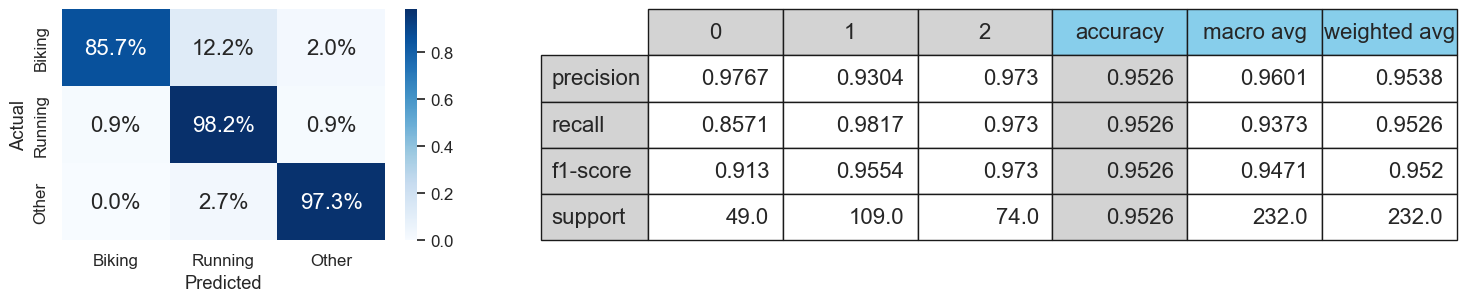

In [102]:
sktime_clfs_e4 = {'ENSEMBLE': clf_emb}
classify_report(sktime_clfs_e4, x_tr, y_tr, x_te, y_te)

In [103]:
results_emb, preds_emb = classify(sktime_clfs_e4, 'sktime-ensemble', x_tr, x_te, y_tr, y_te, results=None, preds=None, iters=3)

Processing  ➥ColumnEnsembleClassifier(estimators=[('STSF1', SupervisedTimeSeriesForest(),    | 0/1 [00:00<?, ?it/s]
Processing  ➥ColumnEnsembleClassifier(estimators=[('STSF1', SupervisedTimeSeriesForest(),
Processing  ➥ColumnEnsembleClassifier(estimators=[('STSF1', SupervisedTimeSeriesForest(),
          
Classification done for sktime-ensemble



In [104]:
results_emb

Classifier             Type    Train(t)    Test(t)   Score_1   Score_2  \
0   ENSEMBLE  sktime-ensemble  771.210743  51.783875  0.956897  0.961207   

    Score_3       mse        f1   roc-auc  
0  0.952586  0.064655  0.961207  0.995724

In [105]:
preds_emb

ENSEMBLE
0           1
1           1
2           1
3           1
4           1
..        ...
227         2
228         0
229         1
230         0
231         1

[232 rows x 1 columns]

> Save results to a file

In [106]:
save_to_file('results','ENSEMBLE',results_emb)

Results saved into file: results_datasetup_b_D20230504_T1944.csv


Classifier             Type    Train(t)    Test(t)   Score_1   Score_2  \
0   ENSEMBLE  sktime-ensemble  771.210743  51.783875  0.956897  0.961207   

    Score_3       mse        f1   roc-auc  
0  0.952586  0.064655  0.961207  0.995724

In [107]:
save_to_file('predictions','ENSEMBLE',preds_emb)

Predictions saved into file: preds_datasetup_b_D20230504_T1944.csv


ENSEMBLE
0           1
1           1
2           1
3           1
4           1
..        ...
227         2
228         0
229         1
230         0
231         1

[232 rows x 1 columns]

---

<div style="display: block; padding: 15px; background-color: lightgreen; height: auto; border-radius: 5px; width: 95vw;">
    <h3 style="font-size: 26px;"><b>Execution Information</b></h3>
    <p>Works only when the whole file is executed from start to this point</p>
</div>

In [108]:
run_end = datetime.datetime.now()
run_time = run_end - run_start
print('File execution info:')
print('Start\t', run_start)
print('End\t', run_end)
print('Runtime\t', str(run_time))

File execution info:
Start	 2023-05-04 14:01:34.154550
End	 2023-05-04 22:15:37.296528
Runtime	 8:14:03.141978


---

<a id="5"></a> <br>
# [▲](#0) 5 - Test Section

In [109]:
import numpy as np
from sklearn.model_selection import train_test_split
# Some extra time series classifiers from sktime
from sktime.classification.compose import ColumnEnsembleClassifier
from sktime.classification.feature_based import SummaryClassifier
from sktime.classification.interval_based import TimeSeriesForestClassifier
# Data transformation tools from sktime
from sktime.transformations.panel.compose import ColumnConcatenator
from sktime.transformations.panel.segment import RandomIntervalSegmenter
from sktime.transformations.panel.shapelet_transform import ShapeletTransform
# Model tuning tools
from sklearn.model_selection import GridSearchCV, StratifiedKFold
# Dataset for testing purposes
from sktime.datasets import load_basic_motions
# Pipeline
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
# Metrics
from sklearn.metrics import roc_auc_score
from sktime.datasets import load_unit_test

<a id="51"></a> <br>
### [▲](#5) 5A - Column Ensemble in "Basic Motions" dataset

**Functions**

Confusion matrix plot function (for 4 class in test data)

In [110]:
def plot_confmatrix_4(ax, yval, ypred):
    cm = pd.DataFrame(confusion_matrix(yval, ypred))
    cm_norm = cm.apply(lambda x: x/x.sum(), axis = 1)
    sns.set(font_scale=1.1) # for label size
    sns.heatmap(cm_norm, annot=True, xticklabels=('Pred A1', 'Pred A2','Pred A3','Pred A4'), 
                                     yticklabels=('Act A1', 'Act A2','Act A3','Act A4'),
                                     fmt='.1%',
                                     cmap='Blues',
                                     ax=ax,
                                     annot_kws={"size": 16}) # font size

**Data**

In [111]:
X_train, y_train = load_basic_motions(split="train")
X_test, y_test = load_basic_motions(split="test")

In [112]:
X_train.head(5)

dim_0  \
0  0     0.079106
1     0.079106
2    -0.903497
3...   
1  0     0.377751
1     0.377751
2     2.952965
3...   
2  0    -0.813905
1    -0.813905
2    -0.424628
3...   
3  0     0.289855
1     0.289855
2    -0.669185
3...   
4  0    -0.123238
1    -0.123238
2    -0.249547
3...   

                                               dim_1  \
0  0     0.394032
1     0.394032
2    -3.666397
3...   
1  0    -0.610850
1    -0.610850
2     0.970717
3...   
2  0     0.825666
1     0.825666
2    -1.305033
3...   
3  0     0.284130
1     0.284130
2    -0.210466
3...   
4  0     0.379341
1     0.379341
2     0.541501
3...   

                                               dim_2  \
0  0     0.551444
1     0.551444
2    -0.282844
3...   
1  0    -0.147376
1    -0.147376
2    -5.962515
3...   
2  0     0.032712
1     0.032712
2     0.826170
3...   
3  0     0.213680
1     0.213680
2     0.252267
3...   
4  0    -0.286006
1    -0.286006
2     0.208420
3...   

                                               dim_3  \
0  0     0.351565
1     0.351565
2    -0.095881
3...   
1  0    -0.103872
1    -0.103872
2    -7.593275
3...   
2  0     0.021307
1     0.021307
2    -0.372872
3...   
3  0    -0.314278
1    -0.314278
2     0.018644
3...   
4  0    -0.098545
1    -0.098545
2    -0.023970
3...   

                                               dim_4  \
0  0     0.023970
1     0.023970
2    -0.319605
3...   
1  0    -0.109198
1    -0.109198
2    -0.697804
3...   
2  0     0.122515
1     0.122515
2    -0.045277
3...   
3  0     0.074574
1     0.074574
2     0.007990
3...   
4  0     0.058594
1     0.058594
2     0.175783
3...   

                                               dim_5  
0  0     0.633883
1     0.633883
2     0.972131
3...  
1  0    -0.037287
1    -0.037287
2    -2.865789
3...  
2  0     0.775041
1     0.775041
2     0.383526
3...  
3  0    -0.079901
1    -0.079901
2     0.237040
3...  
4  0    -0.074574
1    -0.074574
2     0.114525
3...

**Estimators (Models)**

In [113]:
estimators = [("STSF", SupervisedTimeSeriesForest(), [0]), 
              ("RISE", RandomIntervalClassifier(), [1, 2])]

**Ensemble**

In [114]:
col_ens = ColumnEnsembleClassifier(estimators=estimators)
col_ens.fit(X_train, y_train)

y_pred = col_ens.predict(X_test)
print('model', accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, digits=3))

model 1.0
              precision    recall  f1-score   support

   badminton      1.000     1.000     1.000        10
     running      1.000     1.000     1.000        10
    standing      1.000     1.000     1.000        10
     walking      1.000     1.000     1.000        10

    accuracy                          1.000        40
   macro avg      1.000     1.000     1.000        40
weighted avg      1.000     1.000     1.000        40



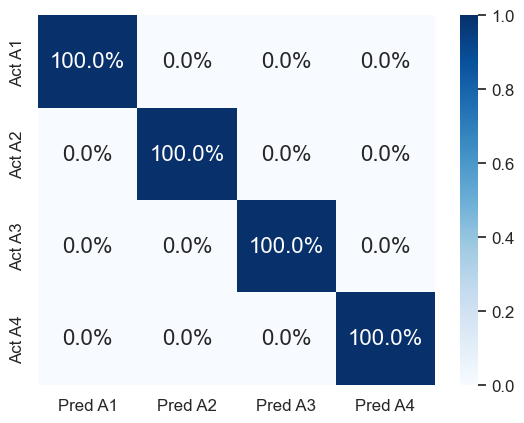

In [116]:
fig = plt.figure()
spec = gridspec.GridSpec(ncols=1, nrows=1, width_ratios=[1], wspace=0.3)
ax = fig.add_subplot(spec[0])
plot_confmatrix_4(ax, y_test, y_pred)

<a id="52"></a> <br>
### [▲](#5) 5B - Hyperparameter list of classifiers

In [ ]:
model_hp = {}
for name, model in sktime_clfs.items():
    hyperparams = model.get_params()
    model_hp[name] = hyperparams

model_hp['MUSE'] = sktime_clfs_e3.get('MUSE').get_params()

def_params = pd.DataFrame(model_hp).dropna(how='all')
def_params.replace(np.nan, '', regex=True)

TSF   STSF   RISE    RIC    STC   kNN-TS  \
min_interval                       3.0          16.0                          
n_estimators                     200.0  200.0  500.0                          
n_jobs                             1.0    1.0    1.0    1.0      1            
acf_lag                                        100.0                          
acf_min_values                                   4.0                          
max_interval                                     0.0                          
n_intervals                                           100.0                   
batch_size                                                     100            
contract_max_n_shapelet_samples                                inf            
n_shapelet_samples                                           10000            
save_transformed_data                                        False            
time_limit_in_minutes                                            0            
transform_limit_in_minutes                                       0            
algorithm                                                             brute   
distance                                                                dtw   
leaf_size                                                                30   
n_neighbors                                                               1   
pass_train_distances                                                  False   
weights                                                             uniform   
bootstrap                                                                     
min_impurity_decrease                                                         
min_samples_leaf                                                              
min_samples_split                                                             
min_weight_fraction_leaf                                                      
oob_score                                                                     
verbose                                                                       
warm_start                                                                    
alphabet_size                                                                 
anova                                                                         
bigrams                                                                       
binning_strategy                                                              
feature_selection                                                             
p_threshold                                                                   
support_probabilities                                                         
window_inc                                                                    
use_first_order_differences                                                   
variance                                                                      

                                  CTSF            WEASEL   MUSE  
min_interval                                                     
n_estimators                       100                           
n_jobs                                                 1      1  
acf_lag                                                          
acf_min_values                                                   
max_interval                                                     
n_intervals                                                      
batch_size                                                       
contract_max_n_shapelet_samples                                  
n_shapelet_samples                                               
save_transformed_data                                            
time_limit_in_minutes                                            
transform_limit_in_minutes                                       
algorithm                                                        
distance                                  

Save to file (Need to be done only once)

In [140]:
def_params.to_csv('setup/TSC_def_params')

In [142]:
model_hp_ = {}
for name, model in sktime_clfs.items():
    hyperparams = model.get_params()
    hyperparams = {k:v for k,v in hyperparams.items() if v is not None}
    model_hp_[name] = hyperparams

model_hp['MUSE'] = sktime_clfs_e3.get('MUSE').get_params()

def_params = pd.DataFrame() # columns=['Model','Default hyperparameters']
def_params['Model'] = list(model_hp_.keys())
def_params['Default hyperparameters'] = list(model_hp_.values())
pd.options.display.max_colwidth = None
def_params

Model  \
0     TSF   
1    STSF   
2    RISE   
3     RIC   
4     STC   
5  kNN-TS   
6    CTSF   
7  WEASEL   

                                                                                                                                                                                          Default hyperparameters  
0                                                                                                                                                           {'min_interval': 3, 'n_estimators': 200, 'n_jobs': 1}  
1                                                                                                                                                                              {'n_estimators': 200, 'n_jobs': 1}  
2                                                                                                  {'acf_lag': 100, 'acf_min_values': 4, 'max_interval': 0, 'min_interval': 16, 'n_estimators': 500, 'n_jobs': 1}  
3                                                                                                                                                                               {'n_intervals': 100, 'n_jobs': 1}  
4              {'batch_size': 100, 'contract_max_n_shapelet_samples': inf, 'n_jobs': 1, 'n_shapelet_samples': 10000, 'save_transformed_data': False, 'time_limit_in_minutes': 0, 'transform_limit_in_minutes': 0}  
5                                                                               {'algorithm': 'brute', 'distance': 'dtw', 'leaf_size': 30, 'n_neighbors': 1, 'pass_train_distances': False, 'weights': 'uniform'}  
6  {'bootstrap': False, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'oob_score': False, 'verbose': 0, 'warm_start': False}  
7     {'alphabet_size': 2, 'anova': True, 'bigrams': True, 'binning_strategy': 'information-gain', 'feature_selection': 'chi2', 'n_jobs': 1, 'p_threshold': 0.05, 'support_probabilities': True, 'window_inc': 2}

<a id="53"></a> <br>
### [▲](#5) 5C - CML model test

> Libraries

In [143]:
# ML models
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier

> Models

In [149]:
sklearn_clfs = {
    'kNN':  KNeighborsClassifier(),
    'G-NB': GaussianNB(),
    'QDA':  QuadraticDiscriminantAnalysis(),
    'LR':   LogisticRegression(),
    'SVM':  SVC(),
    'MLP':  MLPClassifier(),
    'LDA':  LinearDiscriminantAnalysis(),
    'GB':   GradientBoostingClassifier()
}
sklearn_clfs_tree = {
    'DT':   DecisionTreeClassifier(),
    'RF':   RandomForestClassifier(),
}

In [150]:
init_data(SEQ_START, SEQ_END, nest=True, tab=True, std=True)
X_train_tab.head()

0      1           2      3      4           5      6      7    \
0  153.0  3.863  120.400002  152.0  3.872  120.599998  153.0  3.872   
1  164.0  5.421  134.000000  164.0  5.552  133.800003  164.0  5.477   
2  161.0  6.513  124.199997  161.0  5.990  124.599998  161.0  5.981   
3  134.0  8.267  138.199997  134.0  8.276  138.199997  136.0  8.295   
4  138.0  2.715  237.600006  138.0  2.725  237.600006  139.0  2.734   

          8      9    ...         197    198    199         200    201    202  \
0  121.000000  152.0  ...  118.599998  153.0  3.798  118.599998  154.0  3.807   
1  133.800003  163.0  ...  128.800003  162.0  6.457  129.000000  163.0  7.045   
2  125.199997  161.0  ...  123.400002  175.0  6.942  122.400002  175.0  6.681   
3  138.000000  136.0  ...  137.800003  143.0  7.521  137.800003  143.0  7.455   
4  237.600006  139.0  ...  268.200012  185.0  2.538  268.600006  185.0  2.529   

          203    204    205         206  
0  118.400002  154.0  3.807  118.599998  
1  128.600006  162.0  6.774  128.000000  
2  122.000000  175.0  6.653  121.000000  
3  137.800003  144.0  7.334  137.800003  
4  269.000000  185.0  2.529  269.600006  

[5 rows x 207 columns]

In [151]:
X_train_tab_std.head()

0         1         2         3         4         5         6    \
0  0.515939 -0.268068 -0.105836  0.463403 -0.261391 -0.101702  0.506845   
1  1.047489  0.516461  0.186637  1.042852  0.590364  0.182169  1.036423   
2  0.902521  1.066337 -0.024116  0.897990  0.812429 -0.015680  0.891993   
3 -0.402193  1.949561  0.276960 -0.405771  1.971423  0.276792 -0.311595   
4 -0.208902 -0.846142  2.414600 -0.212621 -0.842916  2.414423 -0.167164   

        7         8         9    ...       197       198       199       200  \
0 -0.265472 -0.093268  0.455077  ... -0.152489  0.444786 -0.291610 -0.152880   
1  0.547697  0.182039  0.984045  ...  0.067408  0.882404  1.016649  0.071329   
2  0.803047 -0.002933  0.887869  ... -0.049008  1.514520  1.255274 -0.070957   
3  1.975429  0.272374 -0.314332  ...  0.261434 -0.041456  1.540149  0.261044   
4 -0.842037  2.414606 -0.170068  ...  3.072664  2.000762 -0.911545  3.080903   

        201       202       203       204       205       206  
0  0.488473 -0.292448 -0.157407  0.485323 -0.292568 -0.153623  
1  0.925424  1.302763  0.062485  0.872980  1.169447  0.049017  
2  1.508026  1.123438 -0.079798  1.502923  1.109823 -0.101885  
3 -0.045579  1.504751  0.260819  0.000752  1.445392  0.260281  
4  1.993528 -0.922059  3.089238  1.987494 -0.922314  3.101562  

[5 rows x 207 columns]

In [152]:
results_sklearn, preds_sklearn = classify(sklearn_clfs, 'sklearn', 
                                          X_train_tab_std, X_test_tab_std, 
                                          y_train, y_test, 
                                          results=None, preds=None, 
                                          iters=3)

Processing  ➥QuadraticDiscriminantAnalysis() :  38%|██████▊           | 3/8 [00:01<00:01,  2.98it/s]

c:\Users\jarno\anaconda3\envs\dw\lib\site-packages\sklearn\discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\Users\jarno\anaconda3\envs\dw\lib\site-packages\sklearn\discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\Users\jarno\anaconda3\envs\dw\lib\site-packages\sklearn\discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Processing  ➥LogisticRegression() :  38%|██████████▉                  | 3/8 [00:01<00:01,  2.98it/s]

c:\Users\jarno\anaconda3\envs\dw\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\jarno\anaconda3\envs\dw\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regr

Processing  ➥SVC() :  50%|██████████████████████                      | 4/8 [00:01<00:01,  2.72it/s]

c:\Users\jarno\anaconda3\envs\dw\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Processing  ➥MLPClassifier() :  62%|█████████████████████▎            | 5/8 [00:01<00:01,  2.73it/s]

c:\Users\jarno\anaconda3\envs\dw\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\jarno\anaconda3\envs\dw\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Processing  ➥LinearDiscriminantAnalysis() :  75%|███████████████▊     | 6/8 [00:12<00:06,  3.49s/it]

c:\Users\jarno\anaconda3\envs\dw\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Processing  ➥GradientBoostingClassifier() : 100%|█████████████████████| 8/8 [01:11<00:00,  8.94s/it]
Classification done for sklearn



In [156]:
results_sklearn, preds_sklearn = classify(sklearn_clfs_tree, 'sklearn-tree', 
                                          X_train_tab, X_test_tab, 
                                          y_train, y_test, 
                                          results=results_sklearn, 
                                          preds=preds_sklearn, 
                                          iters=3)

Processing  ➥RandomForestClassifier() : 100%|█████████████████████████| 2/2 [00:05<00:00,  2.72s/it]
Classification done for sklearn-tree



In [157]:
results_sklearn

Classifier          Type   Train(t)   Test(t)   Score_1   Score_2   Score_3  \
0        kNN       sklearn   0.003990  0.160477  0.849138  0.849138  0.849138   
1       G-NB       sklearn   0.014916  0.007418  0.784483  0.784483  0.784483   
2        QDA       sklearn   0.050606  0.012903  0.573276  0.573276  0.573276   
3         LR       sklearn   0.094955  0.009130  0.853448  0.853448  0.853448   
4        SVM       sklearn   0.058334  0.032654  0.883621  0.883621  0.883621   
5        MLP       sklearn   3.131879  0.006906  0.909483  0.909483  0.918103   
6        LDA       sklearn   0.213510  0.012610  0.788793  0.788793  0.788793   
7         GB       sklearn  19.023345  0.005980  0.918103  0.918103  0.918103   
8         DT  sklearn-tree   0.189467  0.005351  0.875000  0.866379  0.870690   
9         RF  sklearn-tree   1.369360  0.023001  0.905172  0.905172  0.896552   

        mse        f1   roc-auc  
0  0.163793  0.849138       NaN  
1  0.215517  0.784483       NaN  
2  0.426724  0.573276       NaN  
3  0.172414  0.853448       NaN  
4  0.129310  0.883621       NaN  
5  0.081897  0.918103       NaN  
6  0.224138  0.788793       NaN  
7  0.081897  0.918103       NaN  
8  0.125000  0.875000  0.898179  
9  0.094828  0.905172  0.979597

In [158]:
preds_sklearn

kNN  G-NB  QDA   LR  SVM  MLP  LDA   GB   DT   RF
0    1.0   1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
1    0.0   0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
2    1.0   1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
3    1.0   1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
4    1.0   1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
..   ...   ...  ...  ...  ...  ...  ...  ...  ...  ...
227  2.0   1.0  1.0  2.0  1.0  2.0  2.0  2.0  2.0  2.0
228  0.0   0.0  1.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0
229  1.0   1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
230  0.0   0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
231  1.0   1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0

[232 rows x 10 columns]

Save results to files for analysis in a separate file

In [162]:
#results_sklearn.to_csv('DATA/results_S-CML_in_TSC/results', index=False)
#preds_sklearn.to_csv('DATA/results_S-CML_in_TSC/preds', index=False)

> Classification reports

DT 0.853448275862069


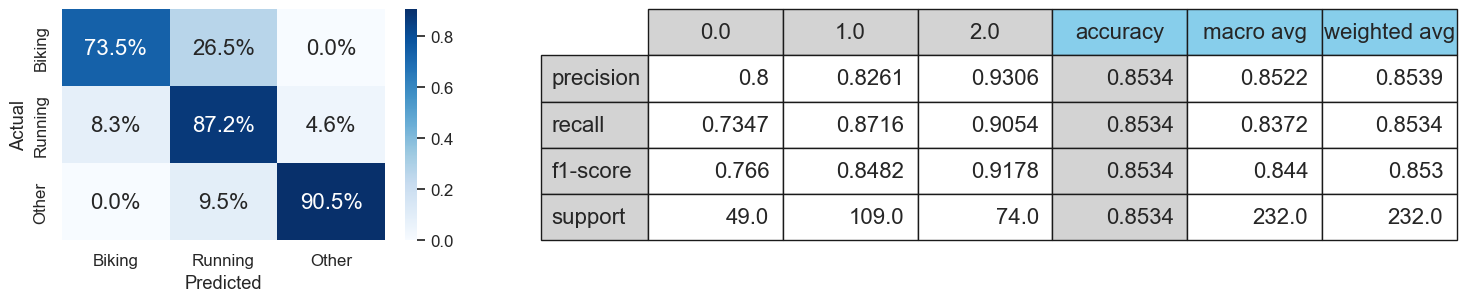

RF 0.9008620689655172


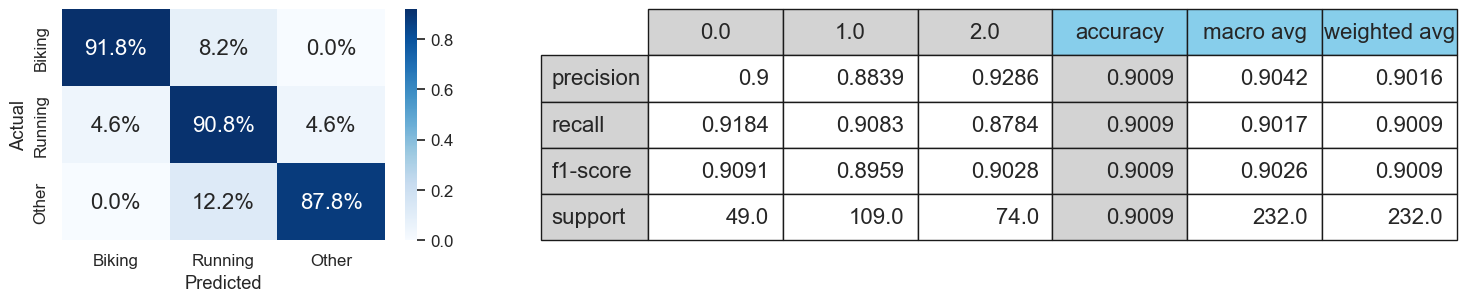

In [154]:
classify_report(sklearn_clfs_tree, X_train_tab, y_train, X_test_tab, y_test)

kNN 0.8491379310344828


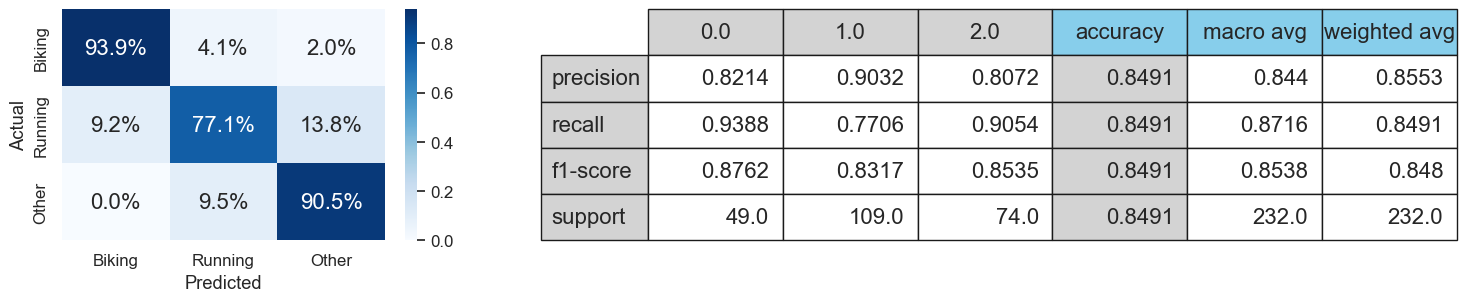

G-NB 0.7844827586206896


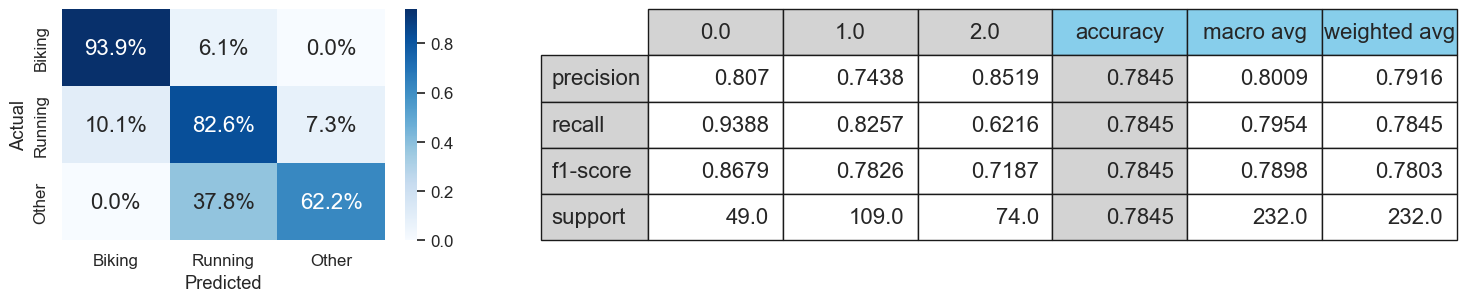

c:\Users\jarno\anaconda3\envs\dw\lib\site-packages\sklearn\discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


QDA 0.5732758620689655


c:\Users\jarno\anaconda3\envs\dw\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\jarno\anaconda3\envs\dw\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\jarno\anaconda3\envs\dw\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


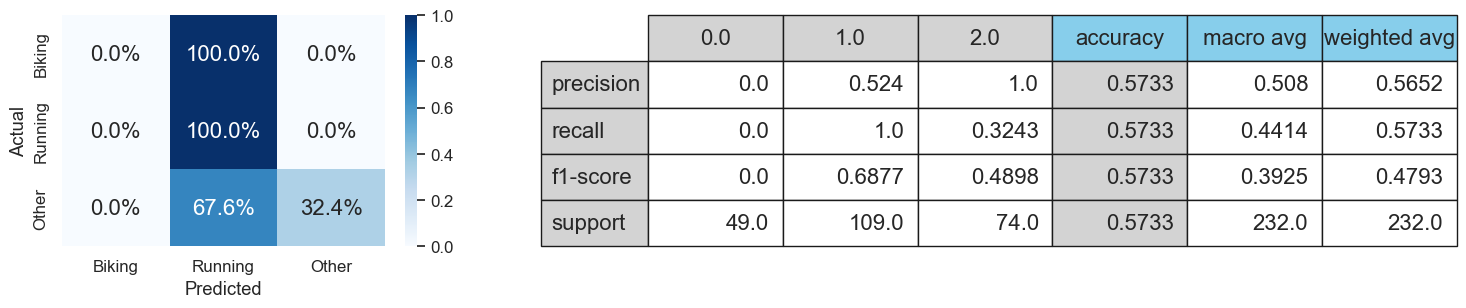

c:\Users\jarno\anaconda3\envs\dw\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LR 0.853448275862069


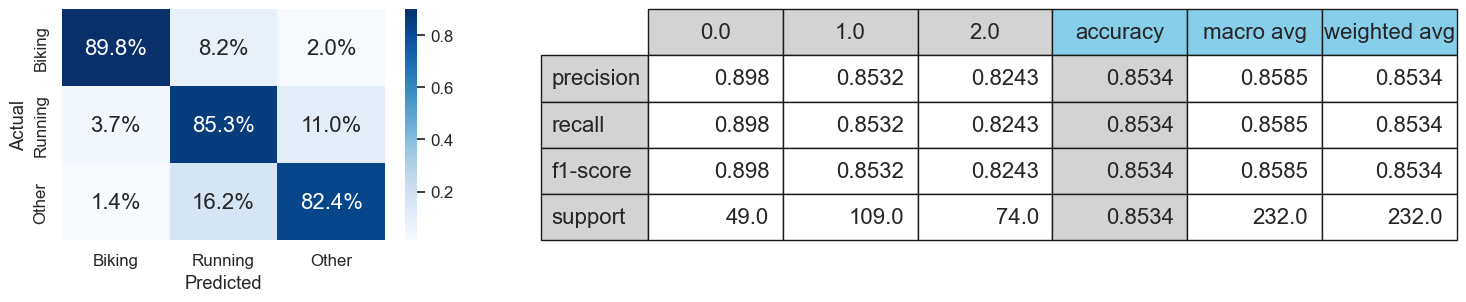

SVM 0.8836206896551724


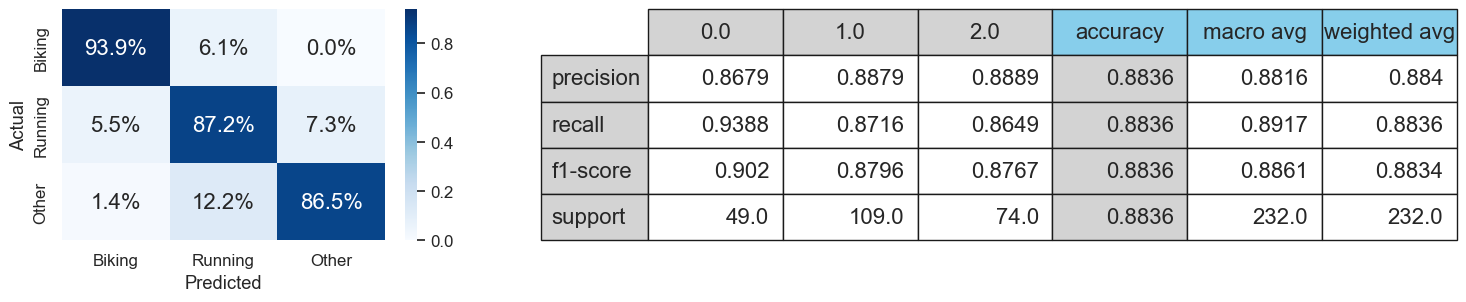

c:\Users\jarno\anaconda3\envs\dw\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLP 0.896551724137931


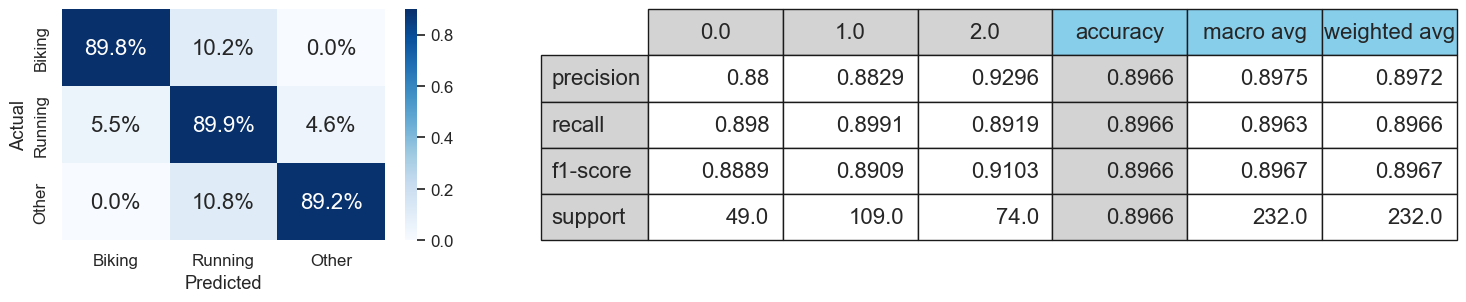

LDA 0.7887931034482759


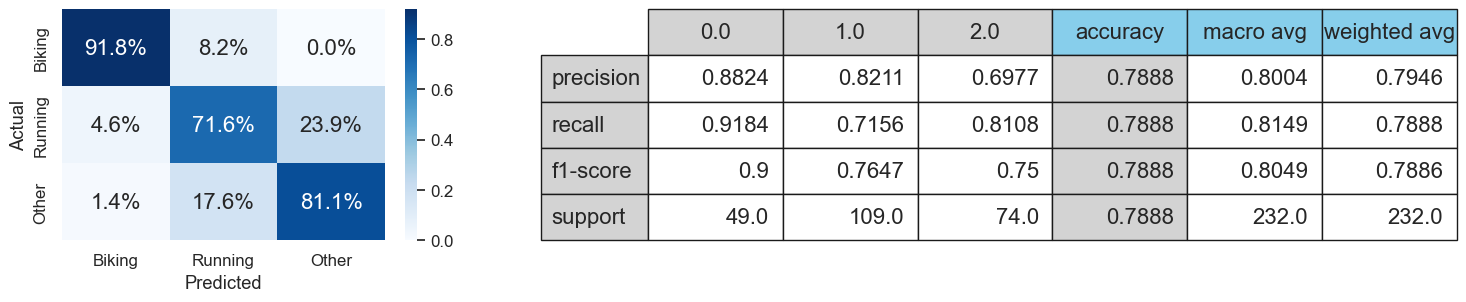

GB 0.9181034482758621


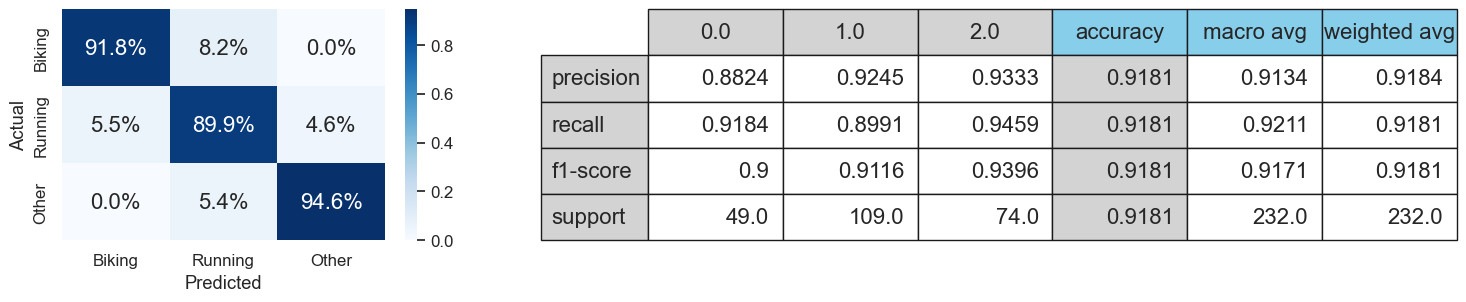

In [159]:
classify_report(sklearn_clfs, X_train_tab_std, y_train, X_test_tab_std, y_test)

### kNN-TS hyperparameter tuning

In [ ]:
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV

In [167]:
kNN_clf = KNeighborsTimeSeriesClassifier()

knn_params = {'n_neighbors':[1,2,3],
              'weights':['uniform','distance'],
              'distance':['dtw','euclidean'],
              'algorithm':['auto'],
              }

clf_search = GridSearchCV(estimator=kNN_clf,
                          refit=True,
                          verbose=1,
                          param_grid=knn_params,
                          cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=24))

In [168]:
clf_search.fit(X_train_nest_std, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=24, shuffle=True),
             estimator=KNeighborsTimeSeriesClassifier(),
             param_grid={'algorithm': ['auto'],
                         'distance': ['dtw', 'euclidean'],
                         'n_neighbors': [1, 2, 3],
                         'weights': ['uniform', 'distance']},
             verbose=1)

In [170]:
knn_best = clf_search.best_estimator_

In [171]:
knn_best

KNeighborsTimeSeriesClassifier(algorithm='auto', distance='euclidean',
                               n_neighbors=2)

kNN 0.8577586206896551


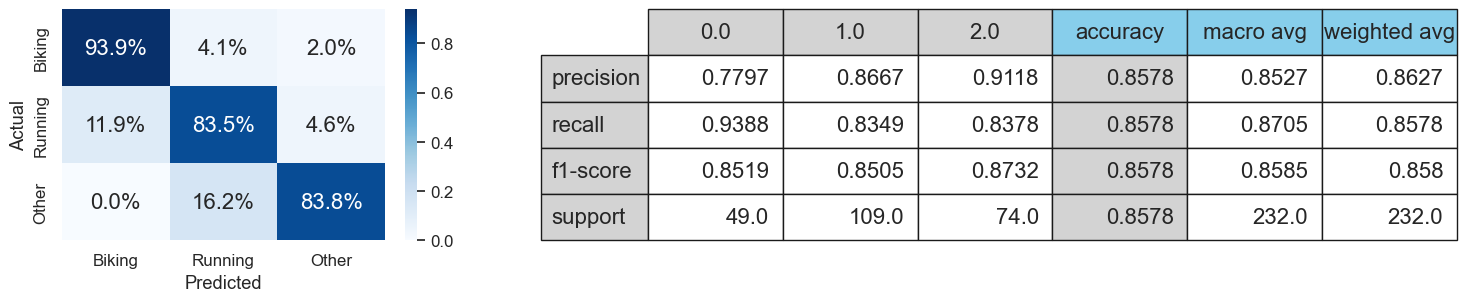

In [172]:
sktime_knn = {'kNN': knn_best}
classify_report(sktime_knn, X_train_nest_std, y_train, X_test_nest_std, y_test)

In [173]:
ITERS = 3

results_knn, preds_knn = classify(sktime_knn, 'sktime', 
                                      X_train_nest_std, X_test_nest_std, 
                                      y_train, y_test, 
                                      results=None, preds=None, 
                                      iters=ITERS)

Processing  ➥KNeighborsTimeSeriesClassifier(algorithm='auto', distance='euclidean',          | 0/1 [00:00<?, ?it/s]
Processing  ➥KNeighborsTimeSeriesClassifier(algorithm='auto', distance='euclidean',
Processing  ➥KNeighborsTimeSeriesClassifier(algorithm='auto', distance='euclidean',
                
Classification done for sktime



In [174]:
results_knn

Classifier    Type  Train(t)   Test(t)   Score_1   Score_2   Score_3  \
0        kNN  sktime  2.222096  0.876357  0.857759  0.857759  0.857759   

        mse        f1  roc-auc  
0  0.155172  0.857759  0.93276

### kNN S-CML hyperparameter tuning

In [193]:
kNNs_clf = KNeighborsClassifier()

knns_params = {'n_neighbors':[1,2,3,4,5,6],
              'weights':['uniform','distance'],
              'metric':['cosine','euclidean','manhattan'],
              'algorithm':['auto', 'ball_tree', 'kd_tree', 'brute'],
              }

clf_search_s = GridSearchCV(estimator=kNNs_clf,
                          refit=True,
                          verbose=1,
                          param_grid=knns_params,
                          cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=24))

In [195]:
clf_search_s.fit(X_train_tab_std, y_train)

Fitting 5 folds for each of 144 candidates, totalling 720 fits


c:\Users\jarno\anaconda3\envs\dw\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
120 fits failed out of a total of 720.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\jarno\anaconda3\envs\dw\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\jarno\anaconda3\envs\dw\lib\site-packages\sklearn\neighbors\_classification.py", line 215, in fit
    return self._fit(X, y)
  File "c:\Users\jarno\anaconda3\envs\dw\lib\site-packages\sklearn\neighbors\_base.py", line 493, in _fit
    self._check_algorithm_metric()
  File "c

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=24, shuffle=True),
             estimator=KNeighborsClassifier(),
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                         'metric': ['cosine', 'euclidean', 'manhattan'],
                         'n_neighbors': [1, 2, 3, 4, 5, 6],
                         'weights': ['uniform', 'distance']},
             verbose=1)

In [196]:
knns_best = clf_search_s.best_estimator_

In [197]:
knns_best

KNeighborsClassifier(metric='euclidean', n_neighbors=2)

kNNs 0.8577586206896551


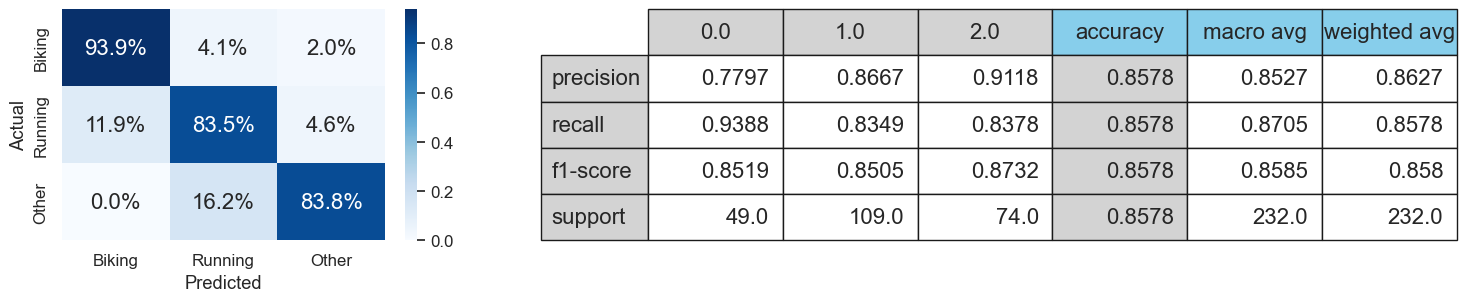

In [198]:
sklearn_knns = {'kNNs': knns_best}
classify_report(sklearn_knns, X_train_tab_std, y_train, X_test_tab_std, y_test)

**The same for TSF**

In [202]:
tsf_clf = TimeSeriesForestClassifier()

tsf_params = {'n_estimators':[100,200,300,400],
              'random_state':[0,24,42]
              }

clf_search_s = GridSearchCV(estimator=tsf_clf,
                          refit=True,
                          verbose=1,
                          param_grid=tsf_params,
                          cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=24))

In [203]:
clf_search_s.fit(X_train_nest_std, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


In [ ]:
tsf_best = clf_search_s.best_estimator_

In [ ]:
tsf_best

In [ ]:
sktime_tsf = {'STSF': tsf_best}
classify_report(sktime_stsf, X_train_nest_std, y_train, X_test_nest_std, y_test)